In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras
from keras import Sequential
import re
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam

In [42]:
#将数据切割为hobbies, foods, and household,并再分为train, validation and test，已经不需要切割了，即不用运行了
def split_data(category):  
    df                = pd.read_csv('train_with_price.csv')
    category_data     = df[df['cat_id'] == category]
    train_df, temp_df = train_test_split(category_data, test_size=0.2, random_state=0)
    test_df, val_df   = train_test_split(temp_df, test_size=0.5, random_state=0)
    train_df.to_csv(f'{category}_train_dataset.csv', index=False)
    test_df.to_csv (f'{category}_test_dataset.csv', index=False)
    val_df.to_csv  (f'{category}_validation_dataset.csv', index=False)

def split_all_data():
    category=['HOUSEHOLD','HOBBIES','FOODS']
    for x in category:
        split_data(x)
split_all_data()

C:\Users\a8090\AppData\Local\Temp\ipykernel_17932\1529081861.py:3: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df                = pd.read_csv('train_with_price.csv')
C:\Users\a8090\AppData\Local\Temp\ipykernel_17932\1529081861.py:3: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df                = pd.read_csv('train_with_price.csv')
C:\Users\a8090\AppData\Local\Temp\ipykernel_17932\1529081861.py:3: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df                = pd.read_csv('train_with_price.csv')


In [3]:
#这里要手动把household改成foods和hobbies
train_data      = pd.read_csv("HOUSEHOLD_train_dataset.csv")
validation_data = pd.read_csv("HOUSEHOLD_validation_dataset.csv")
testing_data    = pd.read_csv("HOUSEHOLD_test_dataset.csv")

#预处理数据-去除不需要的栏，并将数据全部变为数字----
def preprocess_data(data):
    data['item_id']   = data['item_id'].astype(str).apply(lambda x: ''.join(re.findall(r'\d+', x)))
    data['dept_id']   = data['dept_id'].astype(str).apply(lambda x: ''.join(re.findall(r'\d+', x)))
    data.drop(['cat_id'], axis=1, inplace=True)
    data['store_id']  = data['store_id'].astype(str).apply(lambda x: ''.join(re.findall(r'\d+', x)))
    data['state_id']  = data['state_id'].replace({'CA': 1, 'WI': 2, 'TX': 3})
    data['d']         = data['d'].astype(str).apply(lambda x: ''.join(re.findall(r'\d+', x)))
    data.drop(['date'], axis=1, inplace=True)
    data['weekday']   = data['weekday'].replace({'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5 , 'Saturday': 6, 'Sunday': 7})
    data.drop(['event_name_1'], axis=1, inplace=True)
    data.drop(['event_name_2'], axis=1, inplace=True)
    data['event_type_1'] = data['event_type_1'].replace({'Religious': 1, 'Cultural': 1, 'National': 1, 'Sporting': 1})
    data['event_type_2'] = data['event_type_2'].replace({'Religious': 1, 'Cultural': 1, 'National': 1, 'Sporting': 1})
    data['event_type_1'] = data['event_type_1'].fillna(0)   #将活动中空的数据变为0
    data['event_type_2'] = data['event_type_2'].fillna(0)
    data['event_type']   = data['event_type_1']+data['event_type_2']
    data.drop(['event_type_1'], axis=1, inplace=True)
    data.drop(['event_type_2'], axis=1, inplace=True)
    data = data.dropna()
    
preprocess_data(train_data)
preprocess_data(validation_data)
preprocess_data(testing_data)

C:\Users\a8090\AppData\Local\Temp\ipykernel_10024\1590625379.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['state_id']  = data['state_id'].replace({'CA': 1, 'WI': 2, 'TX': 3})
C:\Users\a8090\AppData\Local\Temp\ipykernel_10024\1590625379.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['weekday']   = data['weekday'].replace({'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5 , 'Saturday': 6, 'Sunday': 7})
C:\Users\a8090\AppData\Local\Temp\ipykernel_10024\1590625379.py:18: FutureWarning: Downc

In [4]:
train_data.head()

id item_id dept_id store_id  state_id     d  \
0  HOUSEHOLD_1_225_WI_3_validation    1225       1        3         2  1422   
1  HOUSEHOLD_1_523_TX_3_validation    1523       1        3         3   918   
2  HOUSEHOLD_1_248_TX_3_validation    1248       1        3         3  1070   
3  HOUSEHOLD_1_538_WI_1_validation    1538       1        1         2   490   
4  HOUSEHOLD_2_261_TX_1_validation    2261       2        1         3   383   

   num_sold  wm_yr_wk  weekday  month  year  snap  sell_price  event_type  
0         3     11447        6     12  2014     0        1.64         0.0  
1         0     11328        6      8  2013     1       20.53         0.0  
2         1     11349        4      1  2014     0        8.97         0.0  
3         1     11218        5      6  2012     0        3.48         0.0  
4         0     11203        3      2  2012     1        6.97         0.0

The val_df and eval_df above are in the requested format for Kaggle competition predictions. In the end, we will merge these dataframes into a final consolidated file.

-----------------------------------
Current item is  1225
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_153 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_154 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 18924.4102 - val_loss: 1972.5114
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 3934.3872 - val_loss: 43.5837
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 201.9400 - val_loss: 16.4313
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 107.3859 - val_loss: 15.2957
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 81.3130 - val_loss: 8.4849
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 58.3467 - val_loss: 5.5222
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 34.1280 - val_loss: 3.1466
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 22.7189 - val_loss: 1.6834
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 18.6499 - val_loss: 1.6412
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 14.3320 - val_loss: 1.2821
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 11.1413 - val_loss: 0.9112
Epoch 

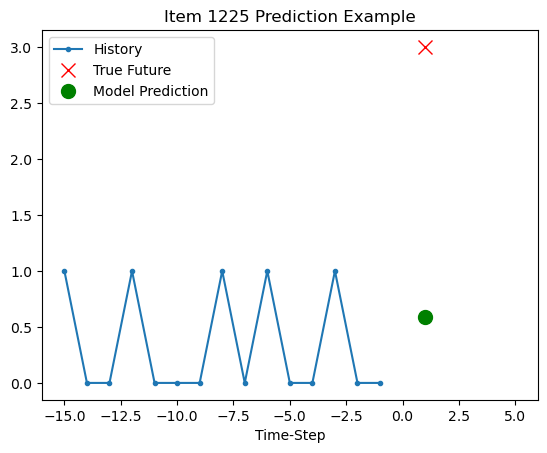

-----------------------------------
Current item is  1523
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_155 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_156 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 14375.5762 - val_loss: 675.8505
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 996.1748 - val_loss: 17.9162
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 112.1268 - val_loss: 2.4032
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 48.4905 - val_loss: 1.3057
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 32.1874 - val_loss: 0.5965
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 20.3652 - val_loss: 0.4104
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 11.1131 - val_loss: 0.2977
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 6.4639 - val_loss: 0.1202
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 4.1530 - val_loss: 0.0690
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 2.6970 - val_loss: 0.0471
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 1.6188 - val_loss: 0.0391
Epoch 12/100
10

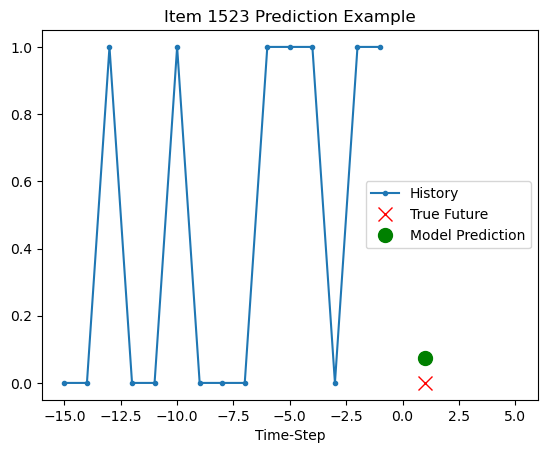

-----------------------------------
Current item is  1248
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_157 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_158 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 24026.9473 - val_loss: 793.8290
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 2744.6355 - val_loss: 227.1237
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 855.1089 - val_loss: 165.0681
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 477.7781 - val_loss: 71.7934
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 172.5361 - val_loss: 30.8414
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 64.1932 - val_loss: 13.4713
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 19.3592 - val_loss: 0.5412
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 3.0346 - val_loss: 0.3821
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 1.9311 - val_loss: 0.2638
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 1.4099 - val_loss: 0.2623
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 1.0135 - val_loss: 0.2730
Epoch 

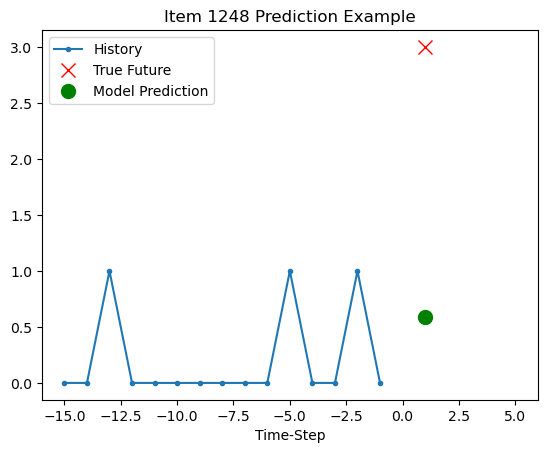

-----------------------------------
Current item is  1538
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_159 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_160 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 41959.0703 - val_loss: 2031.2432
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 6123.6948 - val_loss: 969.4879
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 1905.3384 - val_loss: 406.2067
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 984.2078 - val_loss: 456.9229
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 721.8736 - val_loss: 34.0741
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 146.9604 - val_loss: 12.6738
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 52.8940 - val_loss: 15.0009
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 36.6514 - val_loss: 4.2288
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 20.1532 - val_loss: 2.2451
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 13.7341 - val_loss: 2.9157
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 15.5807 - val_loss: 1.39

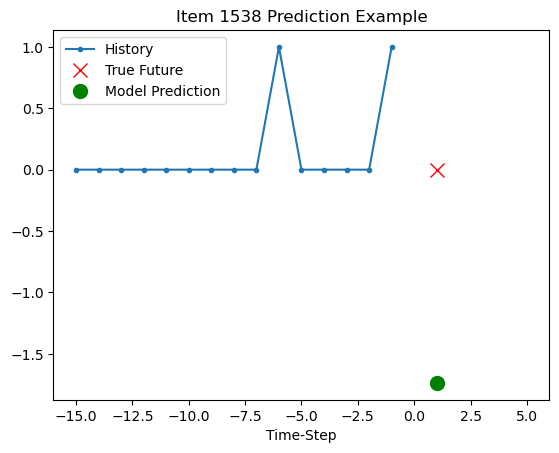

-----------------------------------
Current item is  2261
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_161 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_162 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 18356.6504 - val_loss: 1372.9249
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 2096.1243 - val_loss: 151.5039
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 265.0948 - val_loss: 101.6968
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 266.2577 - val_loss: 24.5295
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 101.3274 - val_loss: 19.5663
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 77.3651 - val_loss: 10.7925
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 42.1672 - val_loss: 9.7049
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 25.9676 - val_loss: 8.7867
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 16.0472 - val_loss: 4.5568
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 12.3033 - val_loss: 7.1910
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 10.7089 - val_loss: 3.0900
E

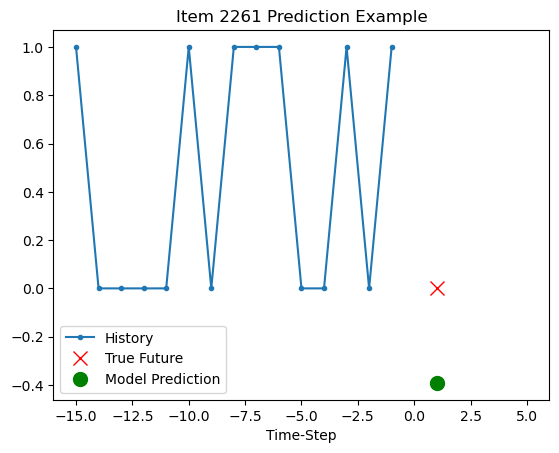

-----------------------------------
Current item is  2103
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_163 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_164 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 23160.5195 - val_loss: 3007.2212
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 4080.3223 - val_loss: 106.1965
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 342.3623 - val_loss: 29.9898
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 118.4812 - val_loss: 14.5527
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 77.4847 - val_loss: 2.6997
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 12.0562 - val_loss: 2.8802
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 10.6096 - val_loss: 0.1044
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 1.0678 - val_loss: 0.0187
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.5533 - val_loss: 0.0227
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.3805 - val_loss: 0.0251
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.4120 - val_loss: 0.0463
Epoch 12/

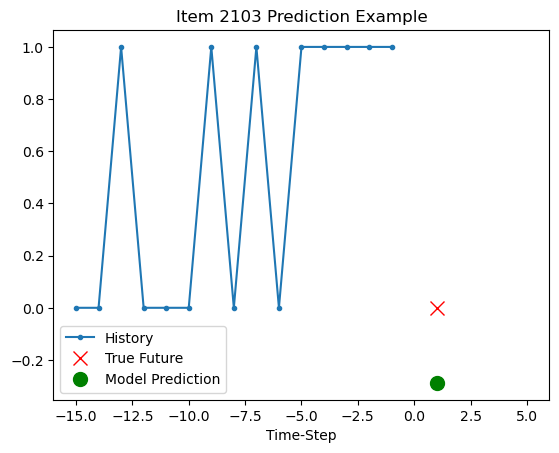

-----------------------------------
Current item is  2475
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_165 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_166 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 9412.5967 - val_loss: 1445.9342
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 2485.5779 - val_loss: 34.6208
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 113.9763 - val_loss: 24.0422
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 71.7826 - val_loss: 13.7146
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 28.8629 - val_loss: 7.3721
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 16.3532 - val_loss: 2.0382
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 10.3375 - val_loss: 1.0634
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 7.5515 - val_loss: 0.3124
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 6.1591 - val_loss: 0.5202
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 4.5108 - val_loss: 0.3067
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 3.1653 - val_loss: 0.1350
Epoch 12/100

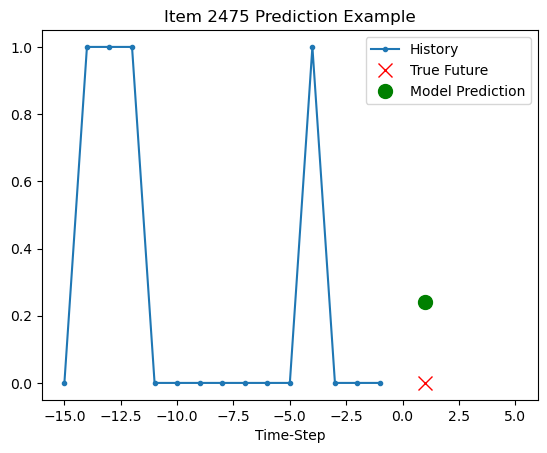

-----------------------------------
Current item is  2359
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_167 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_168 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 9365.9268 - val_loss: 190.7198
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 494.0857 - val_loss: 9.5514
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 73.7295 - val_loss: 3.4019
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 25.3000 - val_loss: 1.3396
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 23.3465 - val_loss: 0.9357
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 14.4071 - val_loss: 0.9817
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 10.2439 - val_loss: 0.4970
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 7.8465 - val_loss: 0.3834
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 5.3499 - val_loss: 0.2635
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 4.8258 - val_loss: 0.1938
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 3.7411 - val_loss: 0.1728
Epoch 12/100
106/1

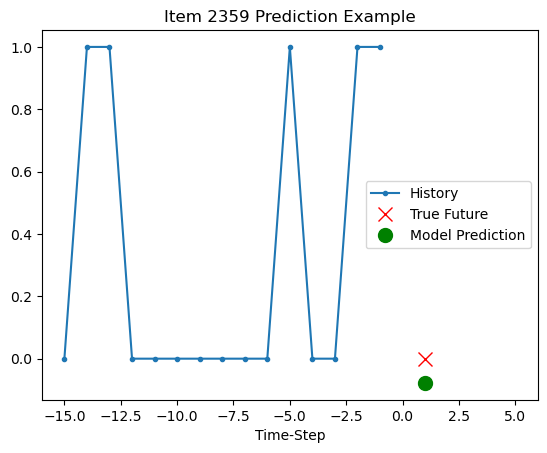

-----------------------------------
Current item is  1428
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_169 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_170 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 38466.8789 - val_loss: 1101.1453
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 4987.2612 - val_loss: 172.3611
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 166.7888 - val_loss: 18.7164
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 55.3474 - val_loss: 2.4334
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 30.0404 - val_loss: 3.2688
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 19.2536 - val_loss: 0.5350
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 13.1905 - val_loss: 0.7582
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 9.1895 - val_loss: 1.1327
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 6.6861 - val_loss: 0.3294
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 4.8286 - val_loss: 0.1445
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 3.5145 - val_loss: 0.3638
Epoch 12/10

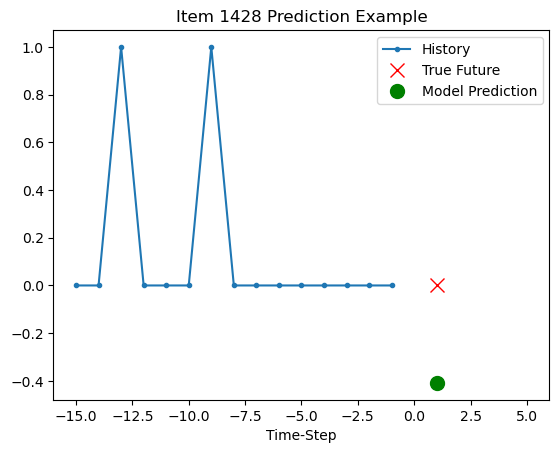

-----------------------------------
Current item is  2237
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_171 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_172 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 35906.1133 - val_loss: 3098.5312
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 9692.7617 - val_loss: 552.1101
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 1690.1912 - val_loss: 175.4864
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 766.7796 - val_loss: 447.1161
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 1100.0265 - val_loss: 79.4871
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 407.0858 - val_loss: 47.7252
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 265.1601 - val_loss: 31.2024
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 184.3420 - val_loss: 22.5759
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 133.9280 - val_loss: 17.4127
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 102.7733 - val_loss: 15.1096
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 80.3628 - val_lo

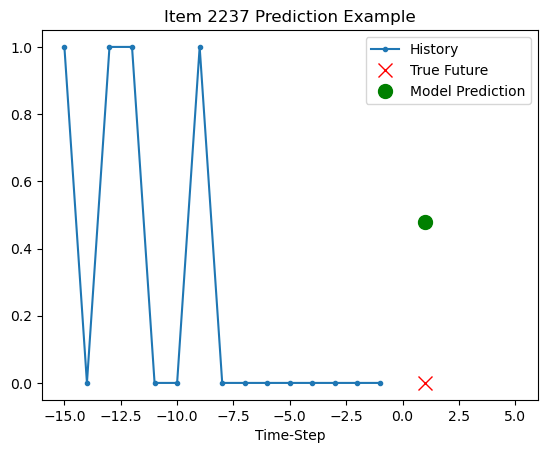

-----------------------------------
Current item is  1016
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_173 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_174 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 8923.8477 - val_loss: 446.0733
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 585.8268 - val_loss: 41.1710
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 75.2053 - val_loss: 2.0860
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 5.8188 - val_loss: 0.0454
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 10.3395 - val_loss: 0.0849
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.9538 - val_loss: 0.0342
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.4927 - val_loss: 0.0214
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 1.1630 - val_loss: 0.1652
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.9384 - val_loss: 0.1279
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.9271 - val_loss: 0.0940
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.6017 - val_loss: 0.0327
Epoch 12/100
106/106

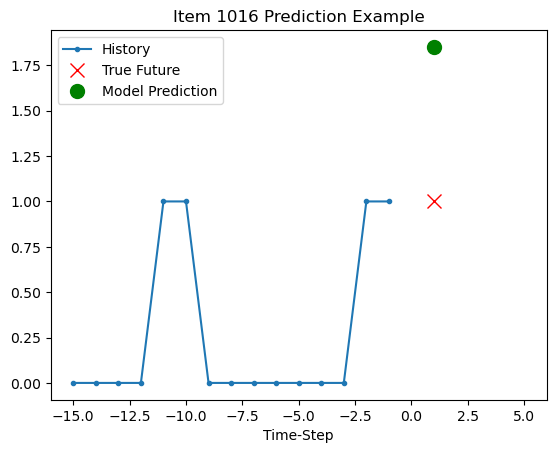

-----------------------------------
Current item is  2114
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_175 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_176 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 34148.1094 - val_loss: 5815.8286
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 4641.6841 - val_loss: 77.1193
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 160.8722 - val_loss: 44.5445
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 45.6440 - val_loss: 23.8772
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 24.9034 - val_loss: 6.7086
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 18.1216 - val_loss: 3.2390
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 11.7563 - val_loss: 1.0781
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 9.5555 - val_loss: 1.2092
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 8.1537 - val_loss: 1.2637
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 6.9849 - val_loss: 0.3593
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 5.9574 - val_loss: 2.4656
Epoch 12/10

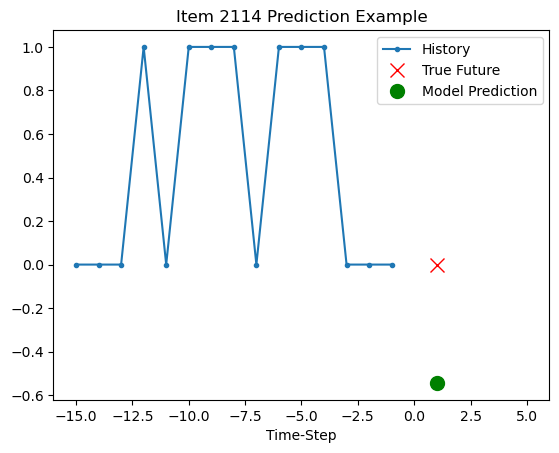

-----------------------------------
Current item is  2236
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_177 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_178 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_83 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 60931.7383 - val_loss: 18196.5117
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 54921.3125 - val_loss: 703.8808
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 2274.4390 - val_loss: 69.0283
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 551.3114 - val_loss: 27.0784
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 261.7172 - val_loss: 14.9578
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 147.7003 - val_loss: 3.5253
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 189.1150 - val_loss: 8.1673
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 248.2841 - val_loss: 13.5123
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 149.0077 - val_loss: 15.1317
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 83.7115 - val_loss: 6.9724
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 60.3978 - val_loss: 4

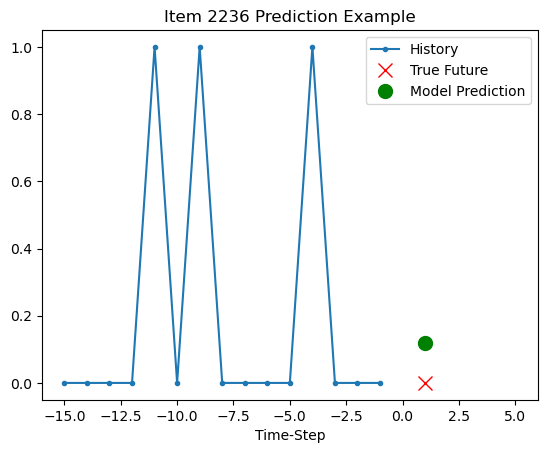

-----------------------------------
Current item is  1172
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_179 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_180 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 28333.6367 - val_loss: 1906.9412
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 2945.6123 - val_loss: 20.3263
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 146.3445 - val_loss: 5.5245
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 54.6891 - val_loss: 2.7626
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 27.4813 - val_loss: 3.5591
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 17.9773 - val_loss: 0.3740
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 12.3851 - val_loss: 1.6670
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 9.3086 - val_loss: 9.4532
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 95.3638 - val_loss: 1.4107
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 59.0693 - val_loss: 0.5416
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 26.8820 - val_loss: 1.9346
Epoch 12/1

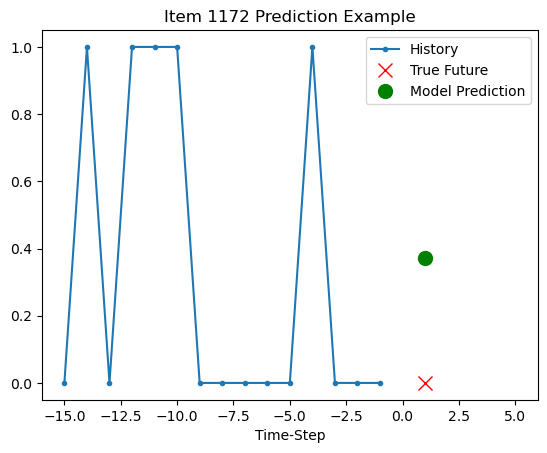

-----------------------------------
Current item is  2443
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_181 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_182 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_87 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 8864.8467 - val_loss: 278.3709
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 636.4620 - val_loss: 42.4217
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 148.2120 - val_loss: 7.5348
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 47.5936 - val_loss: 6.1026
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 33.8543 - val_loss: 2.5773
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 16.4389 - val_loss: 1.7642
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 17.4370 - val_loss: 3.6098
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 11.6453 - val_loss: 0.5502
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 2.2272 - val_loss: 0.1828
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 2.2771 - val_loss: 0.3212
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 2.8712 - val_loss: 0.1371
Epoch 12/100
10

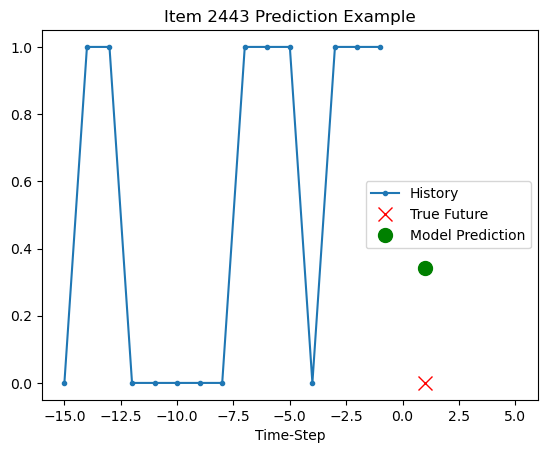

-----------------------------------
Current item is  1004
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_183 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_88 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_184 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_89 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 3144.2327 - val_loss: 33.5587
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 82.9533 - val_loss: 5.7705
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 22.6164 - val_loss: 2.0536
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 8.5708 - val_loss: 0.7341
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 4.7551 - val_loss: 0.9842
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 3.6357 - val_loss: 0.2936
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 2.1022 - val_loss: 0.2480
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 1.5662 - val_loss: 0.5586
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 1.0424 - val_loss: 0.0927
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.7866 - val_loss: 1.0064
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.7424 - val_loss: 0.0536
Epoch 12/100
106/106 ━━━

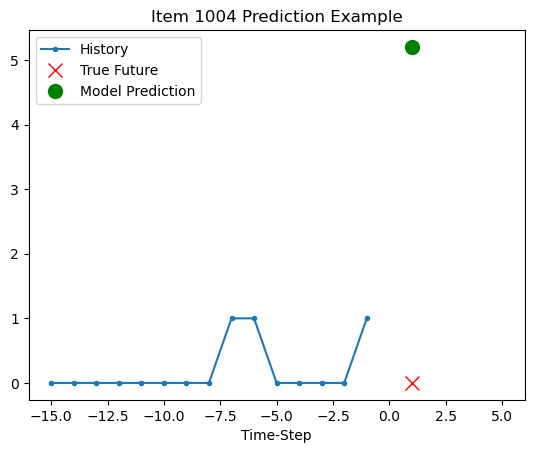

-----------------------------------
Current item is  2297
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_185 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_90 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_186 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_91 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 20200.9199 - val_loss: 2367.4358
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 3315.8997 - val_loss: 40.7881
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 590.1129 - val_loss: 16.0045
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 220.4137 - val_loss: 8.5887
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 112.3401 - val_loss: 1.4584
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 59.8091 - val_loss: 4.6452
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 39.8194 - val_loss: 0.3325
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 25.9247 - val_loss: 0.4017
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 16.2369 - val_loss: 0.1149
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 13.7494 - val_loss: 4.0648
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 7.5500 - val_loss: 0.1244
Epoch 1

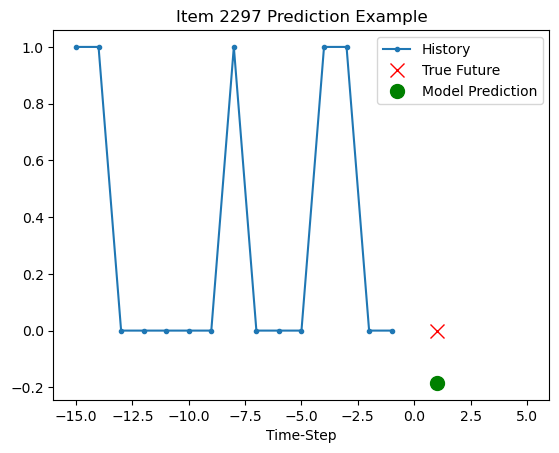

-----------------------------------
Current item is  1347
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_187 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_92 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_188 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_93 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 18057.6504 - val_loss: 2621.0117
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 1595.1162 - val_loss: 31.2051
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 74.5870 - val_loss: 6.8534
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 21.3470 - val_loss: 2.5522
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 9.9546 - val_loss: 1.1069
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 7.5987 - val_loss: 0.4591
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 6.4161 - val_loss: 0.5092
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 2.6037 - val_loss: 0.1205
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.7250 - val_loss: 0.0569
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.4639 - val_loss: 0.0170
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.2334 - val_loss: 0.0588
Epoch 12/100
106/

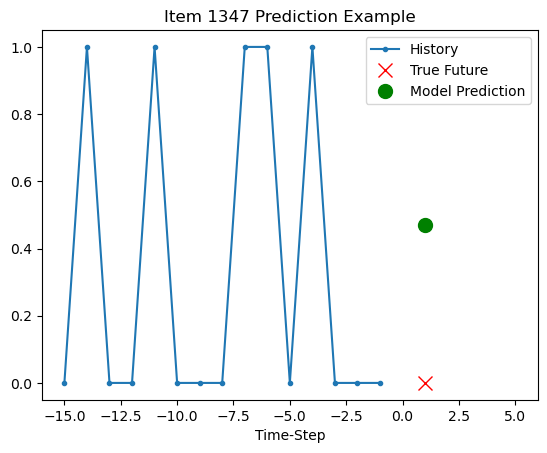

-----------------------------------
Current item is  2507
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_189 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_94 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_190 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_95 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 5045.1255 - val_loss: 14.3661
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 48.3462 - val_loss: 6.0955
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 11.8565 - val_loss: 3.5488
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 5.1381 - val_loss: 1.7383
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 3.1490 - val_loss: 0.6675
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 2.0620 - val_loss: 0.3997
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 1.5252 - val_loss: 0.3390
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 1.0590 - val_loss: 0.1710
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.9370 - val_loss: 0.1428
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.6628 - val_loss: 0.0814
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.6023 - val_loss: 0.2840
Epoch 12/100
106/106 ━━━

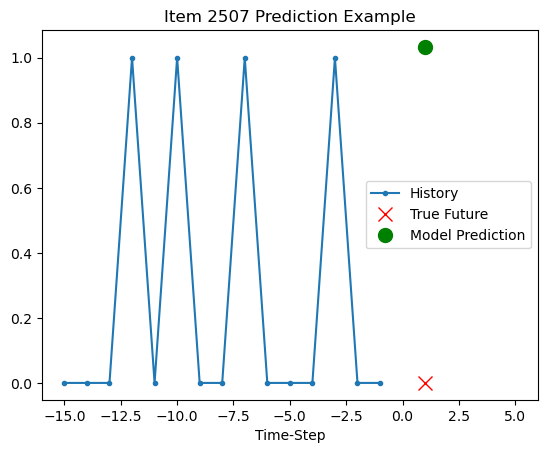

-----------------------------------
Current item is  1505
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_191 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_96 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_192 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_97 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 40563.8398 - val_loss: 8338.0137
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 25712.9648 - val_loss: 878.3768
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 1816.9257 - val_loss: 103.9630
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 488.8260 - val_loss: 69.7238
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 244.5220 - val_loss: 41.8512
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 148.7149 - val_loss: 48.3145
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 88.2482 - val_loss: 30.5061
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 57.4573 - val_loss: 26.2248
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 33.6125 - val_loss: 39.7281
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 24.1754 - val_loss: 8.1977
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 15.9730 - val_loss: 4.

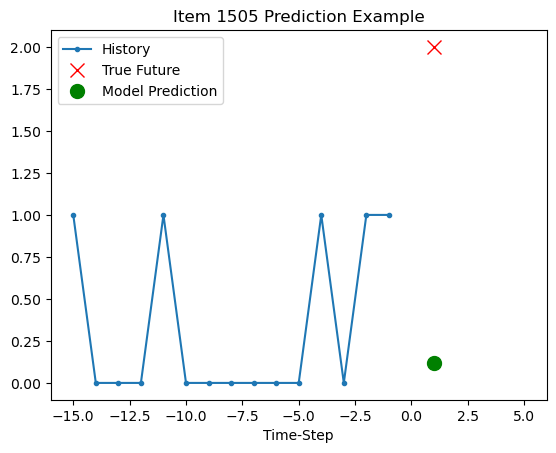

-----------------------------------
Current item is  1460
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_193 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_98 (Dropout)                 │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_194 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_99 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 11100.2441 - val_loss: 428.4152
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 638.3618 - val_loss: 97.8230
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 287.7589 - val_loss: 78.9735
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 187.6889 - val_loss: 18.8228
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 88.0253 - val_loss: 7.6022
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 33.7375 - val_loss: 3.5570
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 21.9986 - val_loss: 1.9975
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 15.2219 - val_loss: 1.5466
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 19.1399 - val_loss: 2.1772
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 17.2427 - val_loss: 1.1211
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 5.1295 - val_loss: 0.3648
Epoch 12/

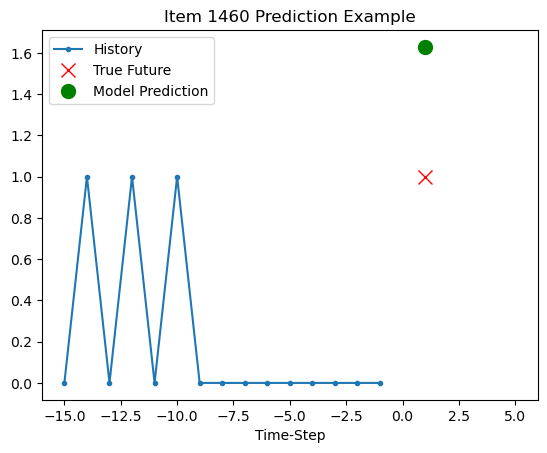

-----------------------------------
Current item is  2212
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_195 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_100 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_196 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_101 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 127880.2969 - val_loss: 52447.6719
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 145171.3750 - val_loss: 181.2726
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 3006.2612 - val_loss: 98.7306
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 1033.6169 - val_loss: 33.7304
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 536.6387 - val_loss: 152.4569
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 387.2451 - val_loss: 57.1825
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 188.3111 - val_loss: 19.5302
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 114.4194 - val_loss: 41.5053
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 102.4929 - val_loss: 15.5725
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 85.3098 - val_loss: 9.8276
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 70.7391 - val_

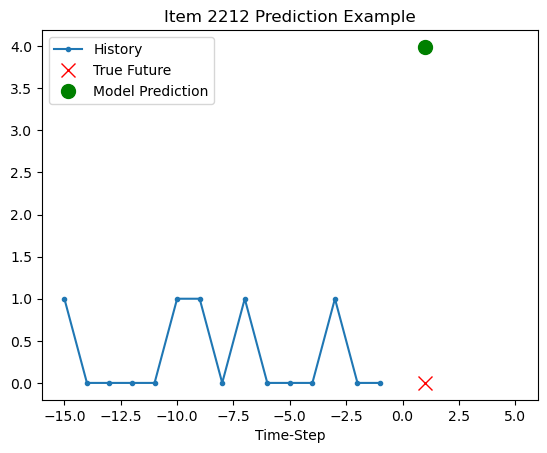

-----------------------------------
Current item is  2467
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_197 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_102 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_198 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_103 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 9249.5352 - val_loss: 210.9825
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 304.1246 - val_loss: 22.1171
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 33.5302 - val_loss: 7.7710
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 9.7997 - val_loss: 1.7165
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 5.7006 - val_loss: 1.5319
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 3.7727 - val_loss: 0.6032
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 2.3605 - val_loss: 0.0444
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 1.4063 - val_loss: 0.0256
Epoch 9/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.9961 - val_loss: 0.0190
Epoch 10/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.6394 - val_loss: 0.0180
Epoch 11/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.4089 - val_loss: 0.0300
Epoch 12/100
105/105 

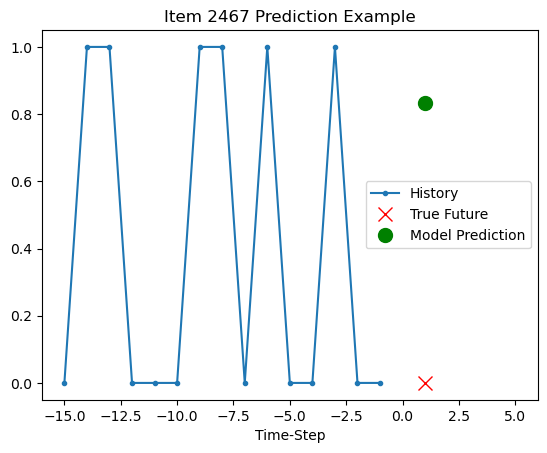

-----------------------------------
Current item is  1489
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_199 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_104 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_200 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_105 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 7672.4600 - val_loss: 53.0347
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 256.7303 - val_loss: 7.7590
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 66.4652 - val_loss: 5.0845
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 27.5519 - val_loss: 3.0844
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 15.1070 - val_loss: 1.3465
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 7.3645 - val_loss: 0.9973
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 5.9534 - val_loss: 0.2510
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 3.2752 - val_loss: 1.0692
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 2.2312 - val_loss: 0.5434
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 1.4472 - val_loss: 0.4504
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 1.3015 - val_loss: 0.2896
Epoch 12/100
106/106

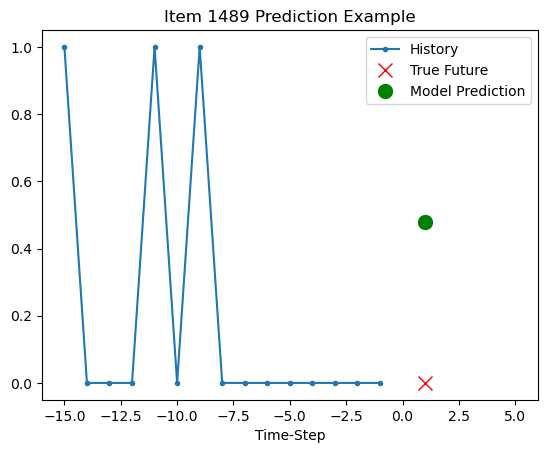

-----------------------------------
Current item is  2365
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_201 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_106 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_202 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_107 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 19351.8379 - val_loss: 717.8820
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 2211.5840 - val_loss: 170.8561
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 666.6846 - val_loss: 38.9263
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 223.2035 - val_loss: 11.7611
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 107.5310 - val_loss: 4.2626
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 69.4284 - val_loss: 1.9447
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 46.7131 - val_loss: 1.1654
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 32.9381 - val_loss: 0.8632
Epoch 9/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 24.0009 - val_loss: 0.5804
Epoch 10/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 17.9426 - val_loss: 0.5417
Epoch 11/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 13.3386 - val_loss: 0.3123
Epoc

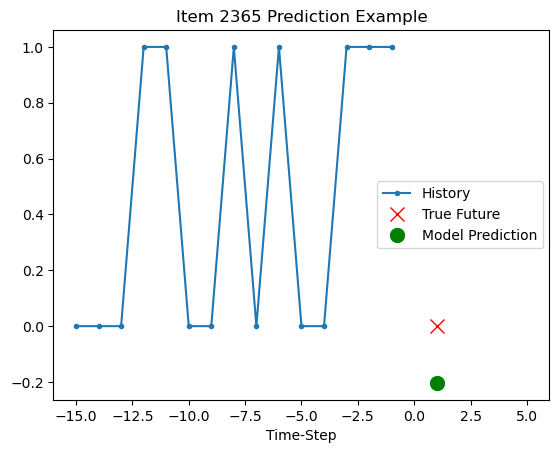

-----------------------------------
Current item is  2260
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_203 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_108 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_204 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_109 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 48576.5898 - val_loss: 3658.3506
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 5587.9824 - val_loss: 62.7286
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 950.8148 - val_loss: 29.5124
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 377.9333 - val_loss: 25.8732
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 250.7539 - val_loss: 17.6715
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 230.8773 - val_loss: 19.0718
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 171.1406 - val_loss: 17.2950
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 124.1863 - val_loss: 13.1629
Epoch 9/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 92.2368 - val_loss: 31.1964
Epoch 10/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 67.4614 - val_loss: 11.5431
Epoch 11/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 54.3078 - val_loss: 14

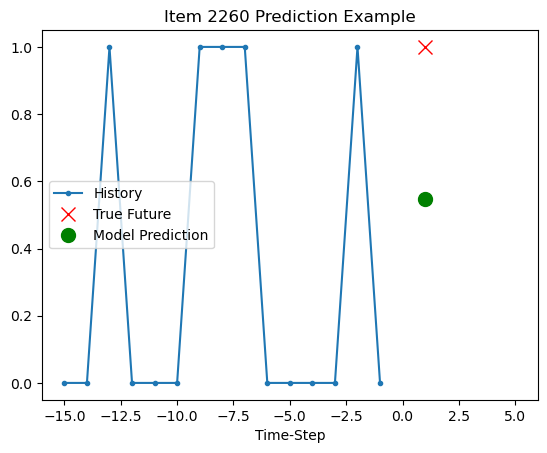

-----------------------------------
Current item is  1518
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_205 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_110 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_206 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_111 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 28168.2852 - val_loss: 254.2339
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 2636.2229 - val_loss: 102.1992
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 588.9793 - val_loss: 58.8910
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 303.7220 - val_loss: 11.9821
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 172.9925 - val_loss: 3.5657
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 128.0503 - val_loss: 2.3995
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 70.0043 - val_loss: 2.1790
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 28.6356 - val_loss: 0.6924
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 17.1386 - val_loss: 0.8472
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 14.5312 - val_loss: 0.5145
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 12.5162 - val_loss: 0.4852
Epo

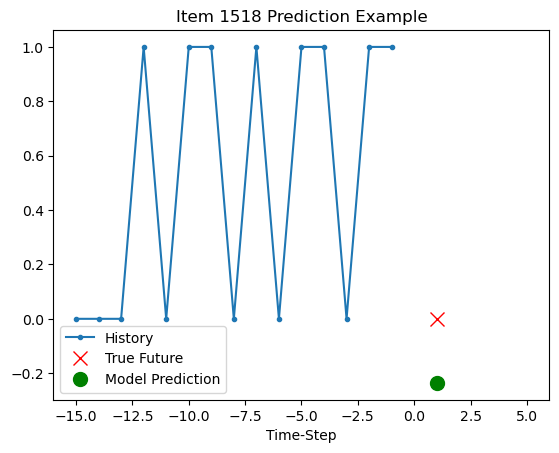

-----------------------------------
Current item is  2215
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_207 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_112 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_208 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_113 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 4645.4214 - val_loss: 13.0466
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 120.0400 - val_loss: 4.4863
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 26.9371 - val_loss: 1.7896
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 13.4880 - val_loss: 2.5927
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 7.6164 - val_loss: 0.1976
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 6.4936 - val_loss: 1.2857
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 5.3539 - val_loss: 0.1656
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 3.1342 - val_loss: 0.7137
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 3.0016 - val_loss: 0.0844
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 2.3135 - val_loss: 0.0360
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 1.2640 - val_loss: 0.0466
Epoch 12/100
106/106 

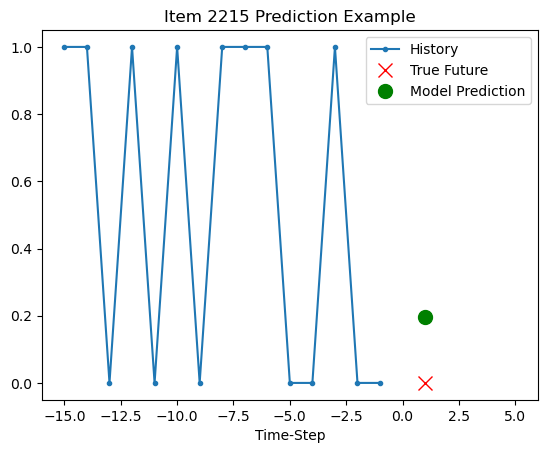

-----------------------------------
Current item is  2302
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_209 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_114 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_210 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_115 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 36783.6797 - val_loss: 21775.6113
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 48349.5000 - val_loss: 806.7084
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 2414.4502 - val_loss: 219.2616
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 768.2894 - val_loss: 94.6791
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 332.0251 - val_loss: 16.7730
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 112.8234 - val_loss: 15.0475
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 62.1705 - val_loss: 8.2675
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 44.2032 - val_loss: 2.9688
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 23.0801 - val_loss: 1.5646
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 14.9223 - val_loss: 1.0083
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 7.1313 - val_loss: 0.47

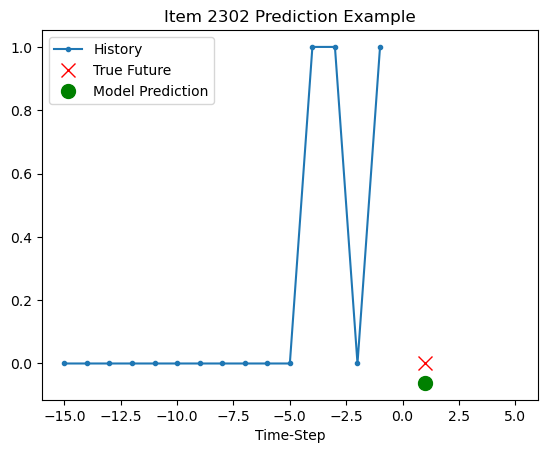

-----------------------------------
Current item is  2374
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_211 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_116 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_212 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_117 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 26126.0391 - val_loss: 762.1906
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 1899.4292 - val_loss: 357.8877
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 815.6359 - val_loss: 111.7471
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 334.9939 - val_loss: 51.3484
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 214.7848 - val_loss: 19.6026
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 123.9470 - val_loss: 15.4822
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 73.9559 - val_loss: 7.8372
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 54.0721 - val_loss: 2.5749
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 23.2246 - val_loss: 1.2953
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 14.5510 - val_loss: 0.9505
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 8.0738 - val_loss: 0.6394
E

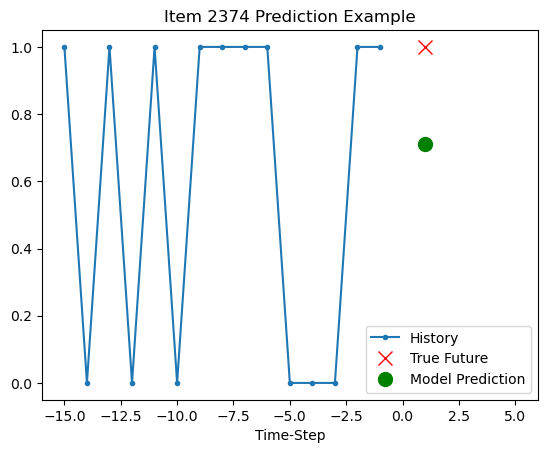

-----------------------------------
Current item is  1251
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_213 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_118 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_214 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_119 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 198958.6406 - val_loss: 24660.7441
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 65067.7812 - val_loss: 493.2159
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 6829.2407 - val_loss: 157.7820
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 1772.8585 - val_loss: 223.5141
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 1119.9945 - val_loss: 299.5569
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 685.0761 - val_loss: 98.6058
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 488.7709 - val_loss: 190.4696
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 294.9742 - val_loss: 40.8018
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 249.2172 - val_loss: 28.5109
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 172.5585 - val_loss: 12.7425
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 145.8395 

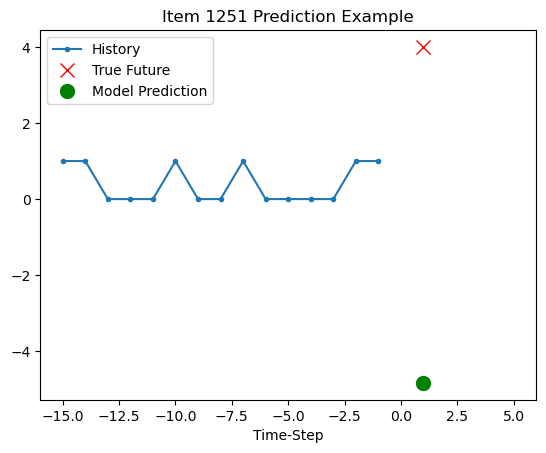

-----------------------------------
Current item is  2163
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_215 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_120 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_216 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_121 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 11166.2637 - val_loss: 162.7639
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 476.2951 - val_loss: 3.2475
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 35.8252 - val_loss: 0.6841
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 10.9624 - val_loss: 0.5782
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 6.3534 - val_loss: 7.2067
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 5.5963 - val_loss: 0.0726
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 2.5653 - val_loss: 0.2542
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 1.6061 - val_loss: 0.4738
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 1.1392 - val_loss: 0.0192
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 1.2895 - val_loss: 8.5263
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 2.1536 - val_loss: 0.0060
Epoch 12/100
106/10

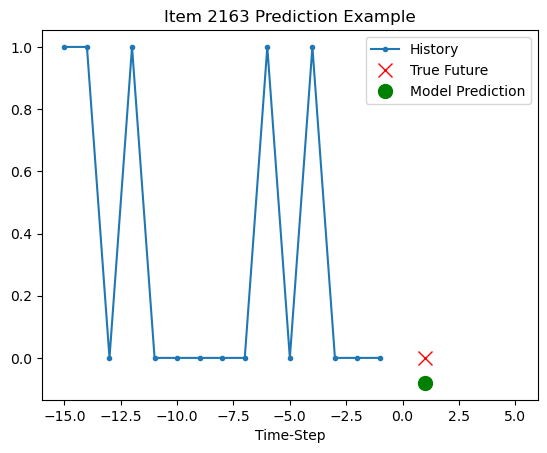

-----------------------------------
Current item is  2482
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_217 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_122 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_218 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_123 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 62949.2891 - val_loss: 15878.2295
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 12563.6553 - val_loss: 955.4444
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 3039.5222 - val_loss: 411.9238
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 1269.3661 - val_loss: 114.8837
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 569.7228 - val_loss: 82.5057
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 820.9339 - val_loss: 57.4599
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 336.9856 - val_loss: 26.7220
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 230.5864 - val_loss: 18.8633
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 151.3792 - val_loss: 11.6601
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 106.7263 - val_loss: 8.1631
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 87.6728 - val_

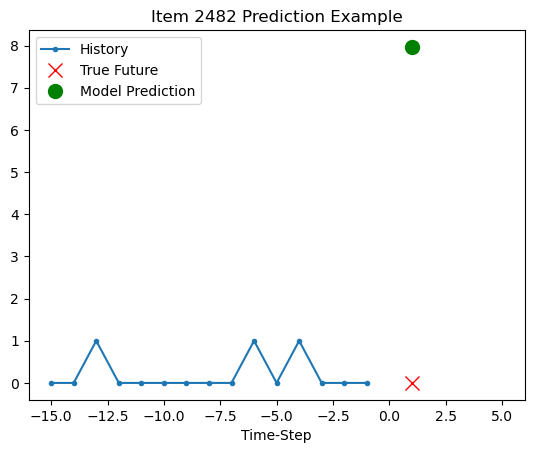

-----------------------------------
Current item is  1119
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_219 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_124 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_220 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_125 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 4667.2827 - val_loss: 40.3608
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 149.6156 - val_loss: 3.3145
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 18.2869 - val_loss: 0.7487
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 4.5521 - val_loss: 0.0388
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.6265 - val_loss: 0.0259
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.3078 - val_loss: 0.0178
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.4413 - val_loss: 0.0161
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.1308 - val_loss: 0.0194
Epoch 9/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.2206 - val_loss: 0.0233
Epoch 10/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0847 - val_loss: 0.0203
Epoch 11/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0813 - val_loss: 0.1220
Epoch 12/100
105/105 ━

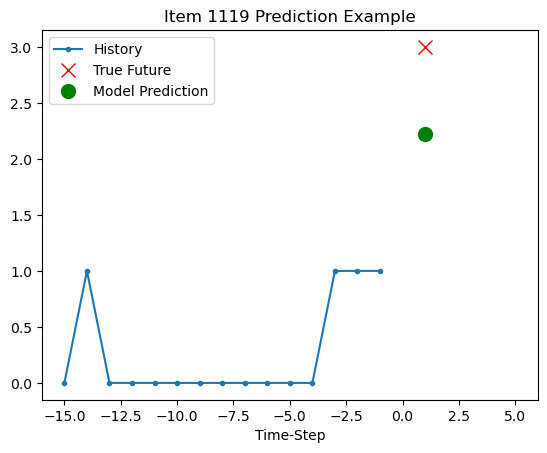

-----------------------------------
Current item is  2190
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_221 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_126 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_222 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_127 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 39265.3594 - val_loss: 1015.3320
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 3172.5127 - val_loss: 272.7464
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 666.9436 - val_loss: 159.3783
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 349.3012 - val_loss: 114.4419
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 157.0905 - val_loss: 5.3141
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 39.1010 - val_loss: 3.2479
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 22.3864 - val_loss: 1.4006
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 27.1769 - val_loss: 59.0822
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 86.9032 - val_loss: 12.1451
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 69.7718 - val_loss: 14.0733
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 26.5413 - val_loss: 2.61

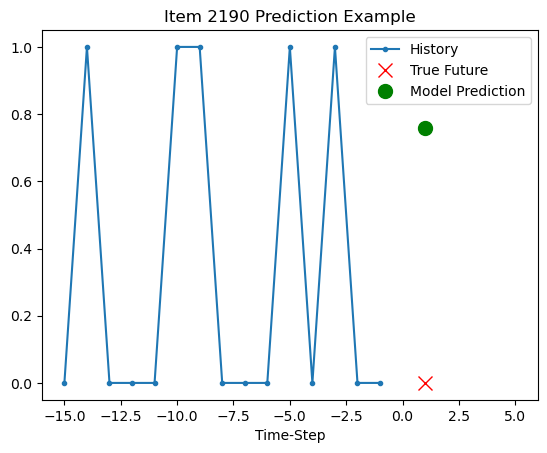

-----------------------------------
Current item is  1071
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_223 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_128 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_224 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_129 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 33086.4414 - val_loss: 108399.0234
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 82340.9531 - val_loss: 1208.8224
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 3363.2764 - val_loss: 164.1846
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 643.6526 - val_loss: 15.8108
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 43.5827 - val_loss: 6.1139
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 8.8013 - val_loss: 8.4074
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 6.8056 - val_loss: 2.9637
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 3.8029 - val_loss: 0.8556
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 2.7172 - val_loss: 1.0129
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 2.1389 - val_loss: 0.7229
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 1.9233 - val_loss: 0.3393
Epo

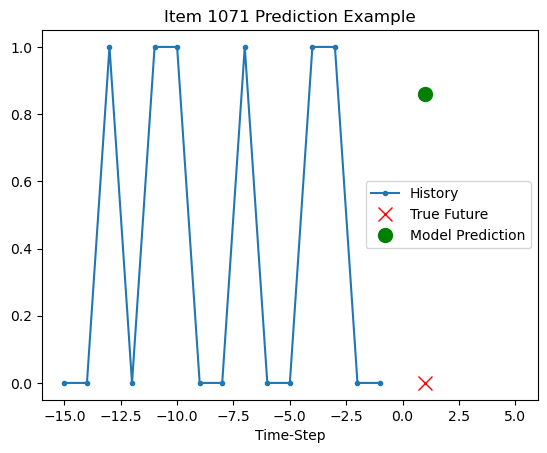

-----------------------------------
Current item is  2035
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_225 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_130 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_226 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_131 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 20651.7949 - val_loss: 796.6826
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 2279.7751 - val_loss: 89.2630
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 312.8403 - val_loss: 4.0923
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 115.8305 - val_loss: 1.7089
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 68.4937 - val_loss: 3.8763
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 40.6137 - val_loss: 1.0619
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 26.6705 - val_loss: 3.3223
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 19.6974 - val_loss: 0.6741
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 16.8798 - val_loss: 0.3387
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 14.2334 - val_loss: 1.6492
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 9.1557 - val_loss: 0.1990

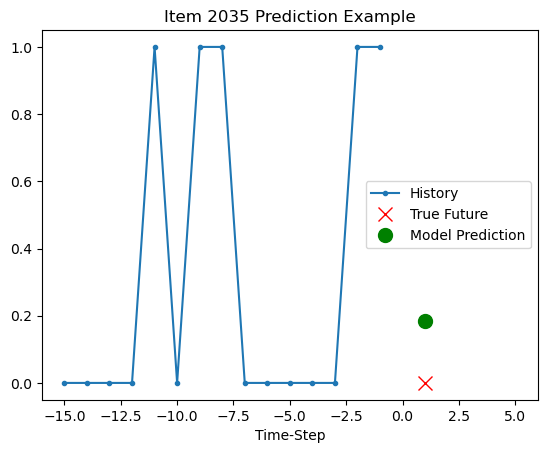

-----------------------------------
Current item is  2370
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_227 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_132 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_228 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_133 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 17818.8613 - val_loss: 831.9936
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 1641.6783 - val_loss: 59.3500
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 353.9845 - val_loss: 22.0156
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 139.8264 - val_loss: 8.9056
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 68.3212 - val_loss: 2.9254
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 41.4184 - val_loss: 1.1886
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 23.6783 - val_loss: 0.7856
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 15.4516 - val_loss: 0.5027
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 12.4206 - val_loss: 1.3853
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 8.3620 - val_loss: 0.3995
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 6.1768 - val_loss: 0.6855

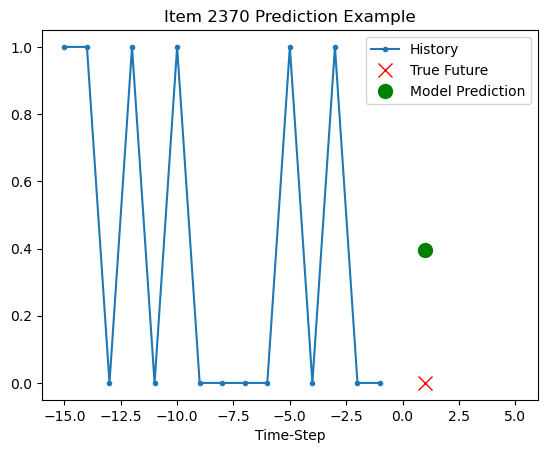

-----------------------------------
Current item is  2444
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_229 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_134 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_230 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_135 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 16581.0645 - val_loss: 190.1826
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 915.2839 - val_loss: 20.9216
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 149.8952 - val_loss: 51.5123
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 278.2110 - val_loss: 16.6080
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 73.6453 - val_loss: 7.2981
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 44.7855 - val_loss: 2.7861
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 32.1076 - val_loss: 1.7387
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 22.3222 - val_loss: 1.1264
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 16.6120 - val_loss: 1.0069
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 11.3983 - val_loss: 1.7574
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 10.1894 - val_loss: 0.58

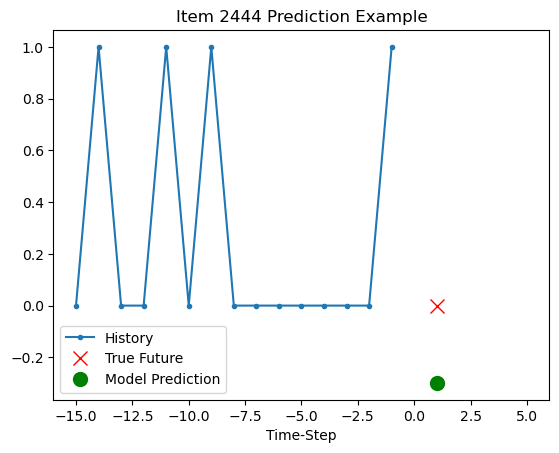

-----------------------------------
Current item is  1339
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_231 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_136 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_232 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_137 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 48266.6172 - val_loss: 3645.6582
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 10425.1650 - val_loss: 1423.9637
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 1290.5101 - val_loss: 195.6954
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 563.1725 - val_loss: 58.0825
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 325.3034 - val_loss: 38.7630
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 204.3329 - val_loss: 39.2156
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 162.8071 - val_loss: 7.1148
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 118.0632 - val_loss: 3.7446
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 68.9065 - val_loss: 3.9367
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 51.6228 - val_loss: 3.2063
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 34.6441 - v

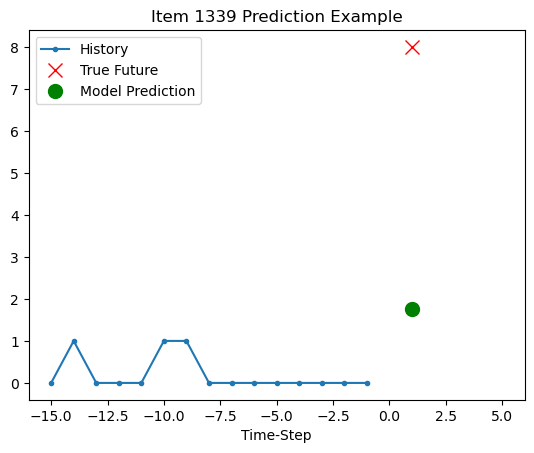

-----------------------------------
Current item is  1168
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_233 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_138 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_234 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_139 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 19570.7969 - val_loss: 11738.8379
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 7685.4756 - val_loss: 66.3188
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 405.8290 - val_loss: 31.9284
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 185.6304 - val_loss: 15.6737
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 96.1528 - val_loss: 9.9086
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 53.6422 - val_loss: 6.2851
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 35.6351 - val_loss: 4.9108
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 24.6292 - val_loss: 4.3806
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 16.7789 - val_loss: 3.3255
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 12.5379 - val_loss: 2.2650
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 8.4458 - val_loss: 1.

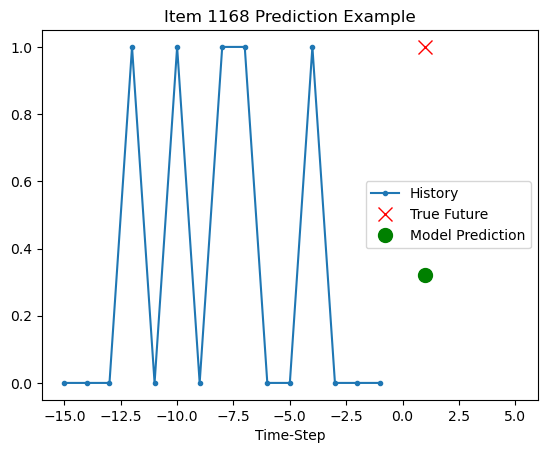

-----------------------------------
Current item is  2470
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_235 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_140 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_236 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_141 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 69991.3125 - val_loss: 15183.8691
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 9160.6084 - val_loss: 449.0584
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 1824.4952 - val_loss: 321.6829
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 930.6652 - val_loss: 160.3697
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 577.0227 - val_loss: 57.4398
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 361.3781 - val_loss: 31.6635
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 200.3084 - val_loss: 18.2972
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 142.6639 - val_loss: 10.3974
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 89.9479 - val_loss: 12.4704
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 102.5629 - val_loss: 12.0472
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 85.45

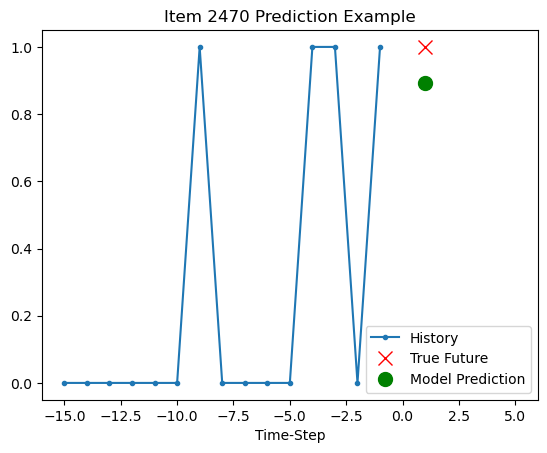

-----------------------------------
Current item is  2451
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_237 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_142 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_238 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_143 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 6962.4102 - val_loss: 97.0596
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 128.7729 - val_loss: 1.3564
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 18.5333 - val_loss: 0.3377
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 9.5818 - val_loss: 0.6846
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 8.1876 - val_loss: 0.6562
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 5.7067 - val_loss: 0.1314
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 3.7670 - val_loss: 0.2134
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 3.1436 - val_loss: 0.1660
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 1.9473 - val_loss: 0.7313
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 1.9534 - val_loss: 0.0603
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 1.5748 - val_loss: 0.1910
Epoch 12/100

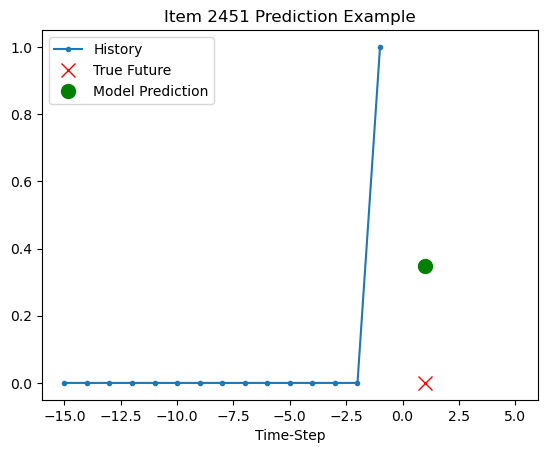

-----------------------------------
Current item is  2092
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_239 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_144 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_240 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_145 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 123705.4062 - val_loss: 53306.6523
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 151662.9531 - val_loss: 883.6946
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 5679.0498 - val_loss: 372.6973
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 1360.1938 - val_loss: 172.1302
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 901.4240 - val_loss: 42.3644
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 192.0967 - val_loss: 22.3896
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 97.5519 - val_loss: 16.9523
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 70.5634 - val_loss: 13.4440
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 76.5573 - val_loss: 7.3779
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 45.8745 - val_loss: 3.7886
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 32.68

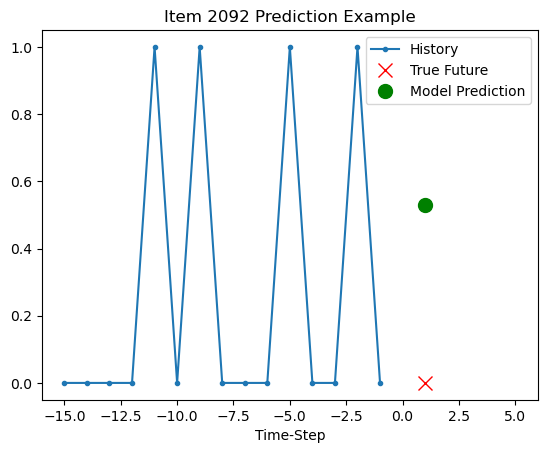

-----------------------------------
Current item is  2346
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_241 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_146 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_242 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_147 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - loss: 4953.7446 - val_loss: 282.4979
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 373.2223 - val_loss: 1.1901
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 10.1258 - val_loss: 0.2302
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 3.6697 - val_loss: 0.0934
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 2.8493 - val_loss: 0.0713
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 2.3891 - val_loss: 0.1119
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 1.6545 - val_loss: 0.1289
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 1.3392 - val_loss: 0.0314
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 1.2406 - val_loss: 0.1396
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.5891 - val_loss: 0.0259
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 0.5974 - val_loss: 0.0224
Epoch 12/1

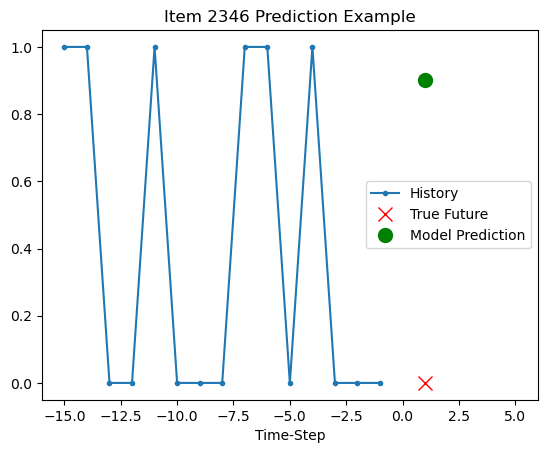

-----------------------------------
Current item is  1385
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_243 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_148 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_244 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_149 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 20203.2441 - val_loss: 466.9173
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 1251.3331 - val_loss: 73.0737
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 158.7083 - val_loss: 18.4454
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 27.2422 - val_loss: 3.0997
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 10.9069 - val_loss: 2.6540
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 5.9858 - val_loss: 1.6445
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 2.1427 - val_loss: 0.7796
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 1.3410 - val_loss: 0.4213
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 1.0756 - val_loss: 0.9193
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 1.0710 - val_loss: 0.3196
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.7817 - val_loss: 

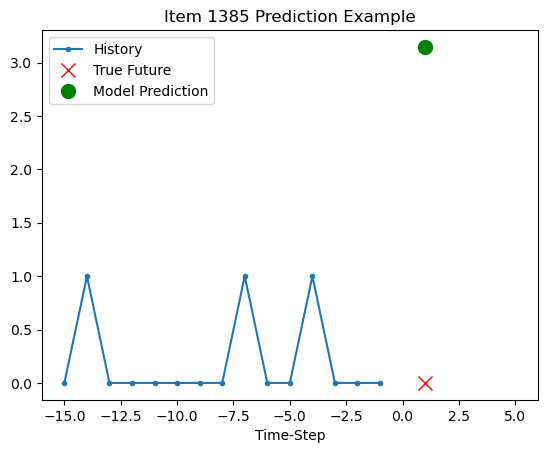

-----------------------------------
Current item is  1418
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_245 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_150 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_246 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_151 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_121 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 33253.5156 - val_loss: 753.2000
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 1835.3767 - val_loss: 108.0670
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 370.0514 - val_loss: 33.2398
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 189.1287 - val_loss: 34.0389
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 107.7196 - val_loss: 17.3671
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 85.1613 - val_loss: 9.4057
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 66.9136 - val_loss: 7.2616
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 47.6285 - val_loss: 13.8233
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 38.1408 - val_loss: 3.2651
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 29.8418 - val_loss: 2.6803
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 21.5605 

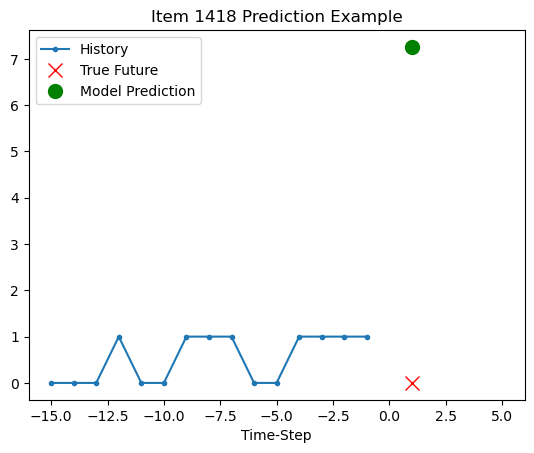

-----------------------------------
Current item is  2218
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_247 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_152 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_248 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_153 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 26117.4531 - val_loss: 1021.0290
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 2339.4175 - val_loss: 100.6271
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 493.4540 - val_loss: 55.7553
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 168.6380 - val_loss: 27.8086
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 94.5537 - val_loss: 8.1227
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 44.8432 - val_loss: 8.1789
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 20.2939 - val_loss: 5.6488
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 12.1928 - val_loss: 4.0152
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 8.2380 - val_loss: 5.2129
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 6.1950 - val_loss: 2.0753
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 4.1176 - val

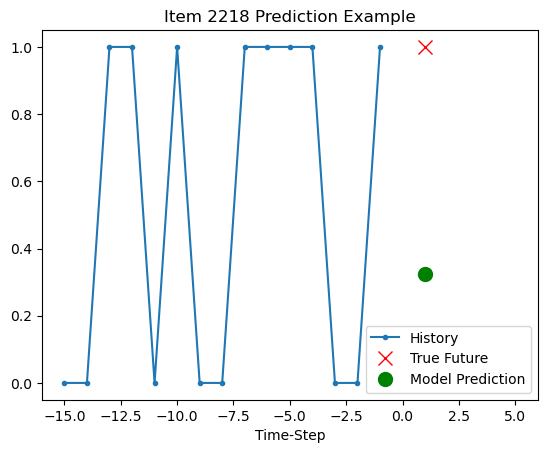

-----------------------------------
Current item is  1372
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_249 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_154 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_250 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_155 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_123 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 5724.9556 - val_loss: 31.0461
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 78.7968 - val_loss: 4.7368
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 18.5161 - val_loss: 2.0129
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 7.3736 - val_loss: 0.2345
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 2.2392 - val_loss: 0.0856
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 1.2214 - val_loss: 0.0450
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.6485 - val_loss: 0.0197
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.4221 - val_loss: 0.0330
Epoch 9/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.4275 - val_loss: 0.0372
Epoch 10/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.2816 - val_loss: 0.0394
Epoch 11/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.1987 - val_loss: 0.0046
Ep

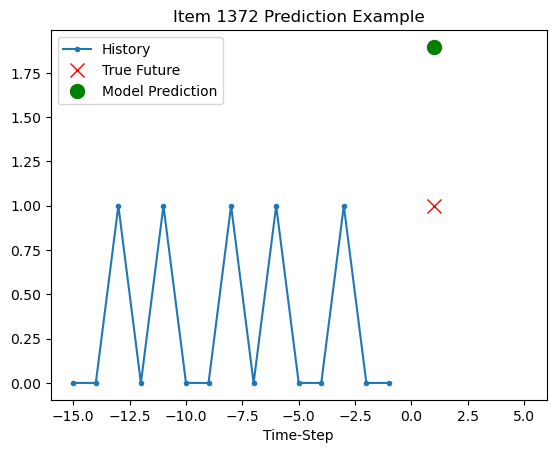

-----------------------------------
Current item is  2091
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_251 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_156 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_252 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_157 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 2399.5427 - val_loss: 5.9515
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 33.9086 - val_loss: 3.0762
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 9.5099 - val_loss: 0.2979
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 4.3145 - val_loss: 1.2266
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 2.8398 - val_loss: 0.1496
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 1.7588 - val_loss: 0.0381
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 1.1148 - val_loss: 0.0973
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 1.0644 - val_loss: 0.4346
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 0.6968 - val_loss: 0.0190
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 0.4938 - val_loss: 0.0293
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 0.4478 - val_loss: 0.0765
Epoch 1

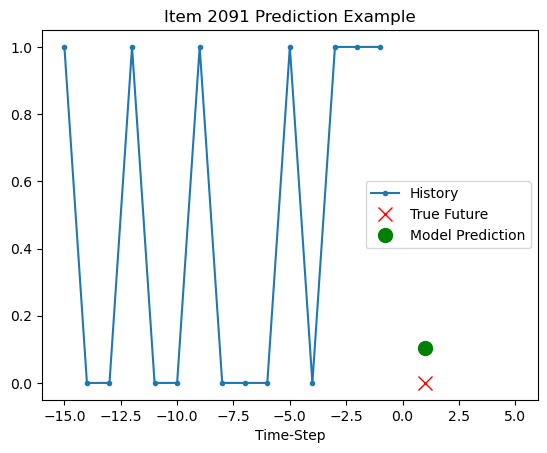

-----------------------------------
Current item is  1321
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_253 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_158 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_254 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_159 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_125 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 26642.7246 - val_loss: 10016.4141
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 8470.3135 - val_loss: 285.4241
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 792.8690 - val_loss: 52.5792
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 329.8942 - val_loss: 59.1814
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 95.6770 - val_loss: 13.1222
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 34.2644 - val_loss: 3.8331
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 13.5210 - val_loss: 2.0641
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 9.1096 - val_loss: 3.1732
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 7.3223 - val_loss: 1.3718
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 5.8122 - val_loss: 1.6456
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 4.9873 - va

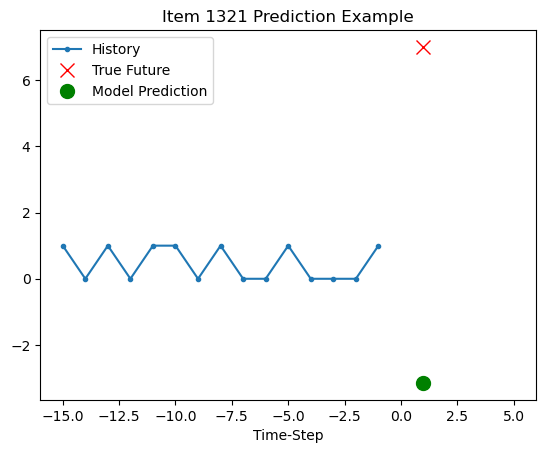

-----------------------------------
Current item is  1060
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_255 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_160 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_256 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_161 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 42605.7500 - val_loss: 81669.3984
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 104442.1250 - val_loss: 371.5465
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 5457.7129 - val_loss: 186.1731
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 3335.4199 - val_loss: 309.5009
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 839.9453 - val_loss: 181.3387
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 521.3579 - val_loss: 70.6890
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 336.7665 - val_loss: 59.7723
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 255.8872 - val_loss: 36.1934
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 174.8770 - val_loss: 16.5178
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 117.3841 - val_loss: 16.3701
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/ste

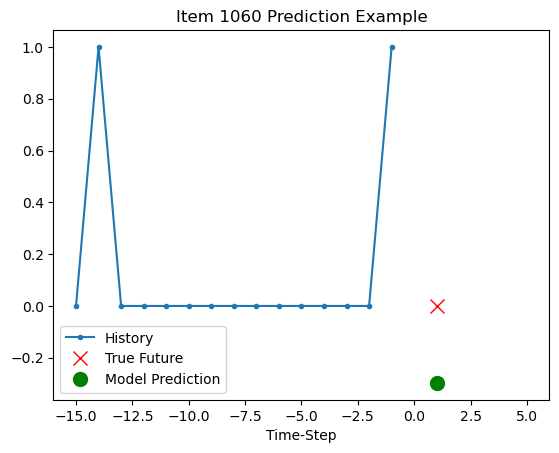

-----------------------------------
Current item is  1465
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_257 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_162 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_258 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_163 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 1777.5757 - val_loss: 99.6648
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 305.4733 - val_loss: 0.5545
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 2.7107 - val_loss: 0.1199
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 1.1199 - val_loss: 0.0443
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.5669 - val_loss: 0.0173
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.3828 - val_loss: 0.1360
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.5657 - val_loss: 0.1505
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.3481 - val_loss: 0.0112
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.2822 - val_loss: 0.0094
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.2367 - val_loss: 0.0058
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.1321 - val_loss: 0.0633
Ep

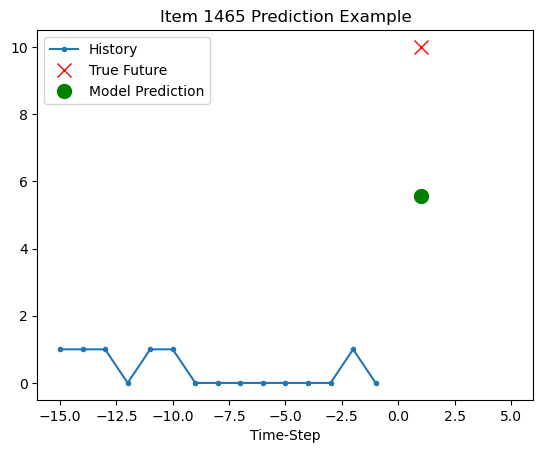

-----------------------------------
Current item is  1291
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_259 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_164 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_260 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_165 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 16102.6553 - val_loss: 811.3441
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 1299.3628 - val_loss: 78.9109
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 193.3227 - val_loss: 49.1470
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 98.2203 - val_loss: 24.8354
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 56.0757 - val_loss: 10.2144
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 34.4090 - val_loss: 9.1613
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 20.9415 - val_loss: 4.4702
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 13.7581 - val_loss: 1.1526
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 9.2829 - val_loss: 1.9566
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 6.3890 - val_loss: 0.3736
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 4.6124 - val_l

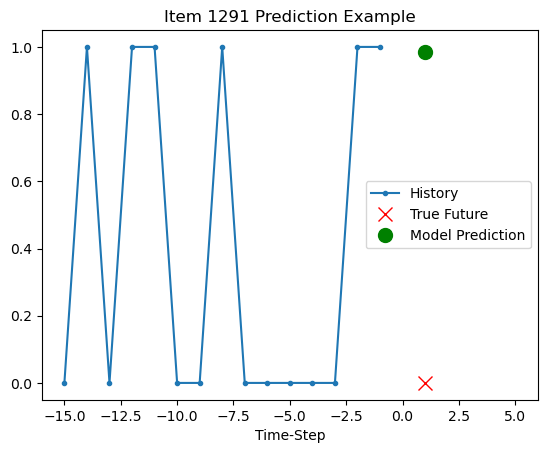

-----------------------------------
Current item is  1424
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_261 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_166 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_262 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_167 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_129 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 16555.3027 - val_loss: 1055.9011
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 1088.1816 - val_loss: 114.7415
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 134.3547 - val_loss: 71.1422
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 78.3459 - val_loss: 42.7679
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 48.7246 - val_loss: 21.2582
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 32.2987 - val_loss: 15.8533
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 23.6187 - val_loss: 7.2489
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 16.4161 - val_loss: 6.7680
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 13.2771 - val_loss: 2.7323
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 10.8621 - val_loss: 4.1661
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 8.6918 - 

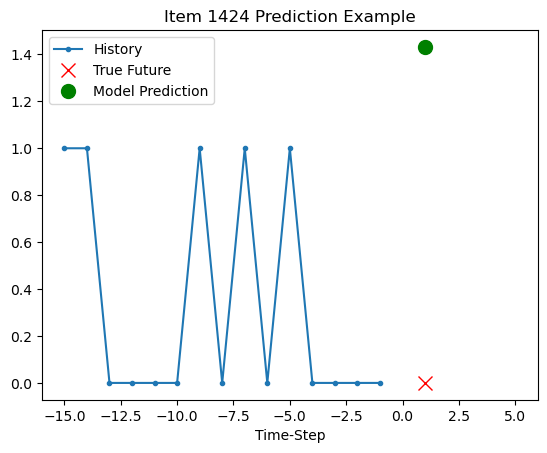

-----------------------------------
Current item is  2504
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_263 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_168 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_264 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_169 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 49501.1250 - val_loss: 1457.8612
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 6897.5859 - val_loss: 291.0981
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 1654.0198 - val_loss: 91.3291
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 591.3803 - val_loss: 53.7344
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 392.3601 - val_loss: 36.7696
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 237.3869 - val_loss: 11.9364
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 151.2194 - val_loss: 10.7370
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 102.2039 - val_loss: 6.6637
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 80.5547 - val_loss: 3.7511
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 55.0267 - val_loss: 3.8237
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 49

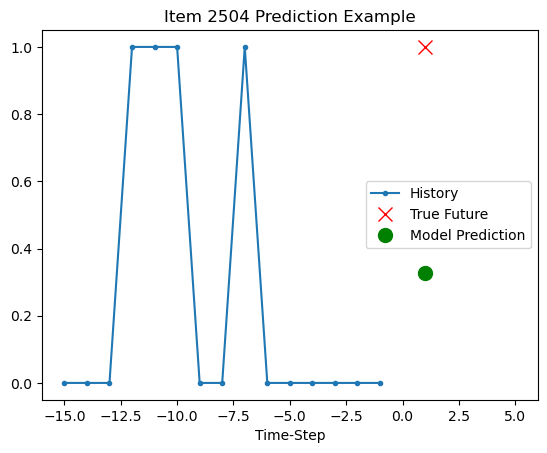

-----------------------------------
Current item is  2010
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_265 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_170 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_266 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_171 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 22493.8184 - val_loss: 2234.3696
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 4772.0278 - val_loss: 62.7961
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 290.8988 - val_loss: 30.0902
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 88.4296 - val_loss: 10.1840
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 38.5198 - val_loss: 2.4335
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 21.9122 - val_loss: 2.6231
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 13.1744 - val_loss: 1.1795
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 8.3515 - val_loss: 0.7782
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 6.0252 - val_loss: 2.7243
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 4.9337 - val_loss: 0.5583
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 2.0704 - val_lo

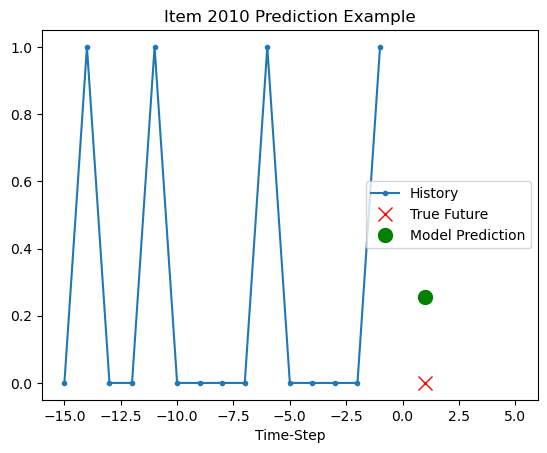

-----------------------------------
Current item is  1445
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_267 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_172 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_268 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_173 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_132 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - loss: 9759.8643 - val_loss: 42.2506
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 377.8294 - val_loss: 18.4006
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 113.0265 - val_loss: 5.9370
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 20.4474 - val_loss: 0.6966
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 5.0812 - val_loss: 0.2164
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 3.0266 - val_loss: 0.6688
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 2.6114 - val_loss: 0.4564
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 1.3599 - val_loss: 0.1441
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.9022 - val_loss: 0.0241
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 0.7821 - val_loss: 0.0576
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.7841 - val_loss: 0.494

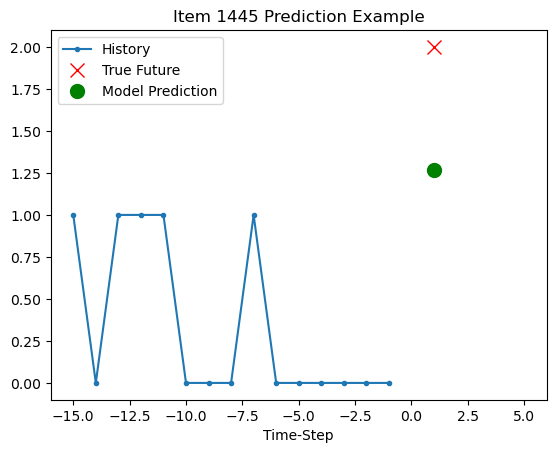

-----------------------------------
Current item is  2012
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_269 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_174 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_270 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_175 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_133 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - loss: 15997.5273 - val_loss: 2057.2039
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 2488.5540 - val_loss: 315.2719
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 788.5375 - val_loss: 24.2098
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 47.0511 - val_loss: 14.1125
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 26.5127 - val_loss: 10.4657
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 17.3912 - val_loss: 2.6465
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 10.8316 - val_loss: 1.3057
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 7.3124 - val_loss: 2.7242
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 5.7847 - val_loss: 0.1239
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 4.8142 - val_loss: 0.1816
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 4.3286 - val_

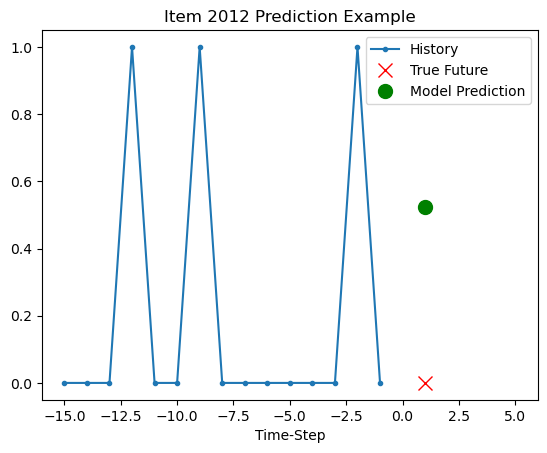

-----------------------------------
Current item is  2168
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_271 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_176 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_272 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_177 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_134 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - loss: 34375.7148 - val_loss: 57160.7188
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 41967.8672 - val_loss: 438.1059
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 3281.5559 - val_loss: 310.9775
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 867.9604 - val_loss: 36.3859
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 343.6973 - val_loss: 40.3279
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 178.7780 - val_loss: 34.3111
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 293.1850 - val_loss: 35.2279
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 296.8963 - val_loss: 18.2245
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 167.3350 - val_loss: 10.5285
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 125.2502 - val_loss: 7.7910
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - l

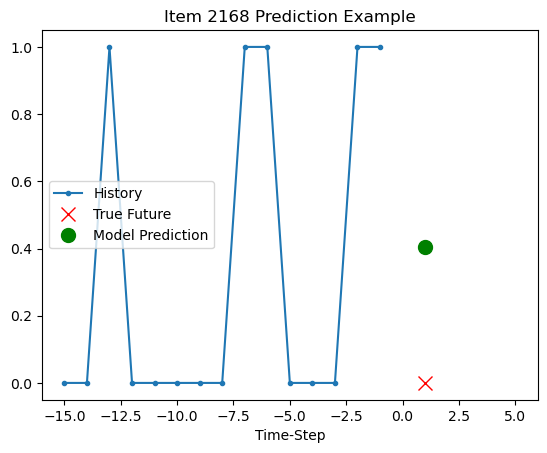

-----------------------------------
Current item is  1050
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_273 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_178 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_274 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_179 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_135 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - loss: 25401.0293 - val_loss: 5332.6982
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 7934.6445 - val_loss: 215.2274
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 841.3720 - val_loss: 54.8551
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 351.6442 - val_loss: 27.3799
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 199.8824 - val_loss: 14.0569
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 126.3875 - val_loss: 10.4290
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 87.8577 - val_loss: 7.3625
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 72.2663 - val_loss: 8.3979
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 53.3199 - val_loss: 5.0769
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 45.1260 - val_loss: 4.8873
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 33.235

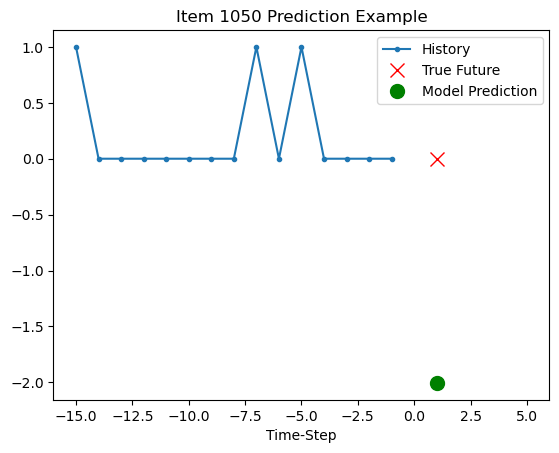

-----------------------------------
Current item is  1177
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_275 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_180 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_276 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_181 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_136 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - loss: 44624.7773 - val_loss: 2902.3999
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 10833.3096 - val_loss: 703.4358
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 2914.1763 - val_loss: 324.6014
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 1799.7914 - val_loss: 170.4707
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 1145.2549 - val_loss: 154.1617
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 747.6458 - val_loss: 162.2749
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 553.6264 - val_loss: 120.6299
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 408.1453 - val_loss: 91.0298
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 318.3636 - val_loss: 48.3396
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 195.3276 - val_loss: 25.2634
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/st

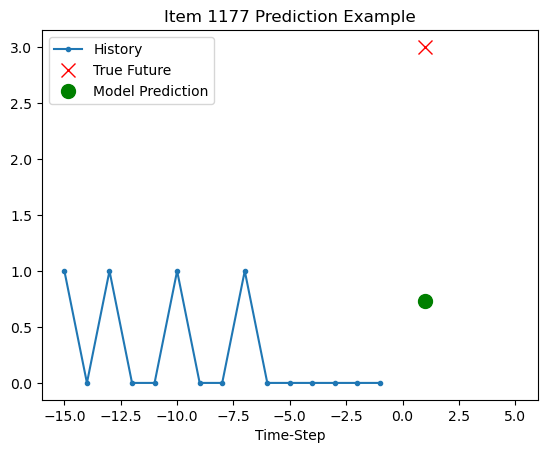

-----------------------------------
Current item is  2156
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_277 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_182 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_278 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_183 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_137 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - loss: 8290.8770 - val_loss: 111.9026
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 338.8893 - val_loss: 5.1481
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 61.8050 - val_loss: 2.0055
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 10.5168 - val_loss: 0.1029
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 1.3678 - val_loss: 0.1296
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 0.6785 - val_loss: 0.0467
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.3826 - val_loss: 0.3447
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.2585 - val_loss: 0.0316
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.2597 - val_loss: 0.8128
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 0.3207 - val_loss: 0.0954
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 0.1307 - val_loss: 0.0302

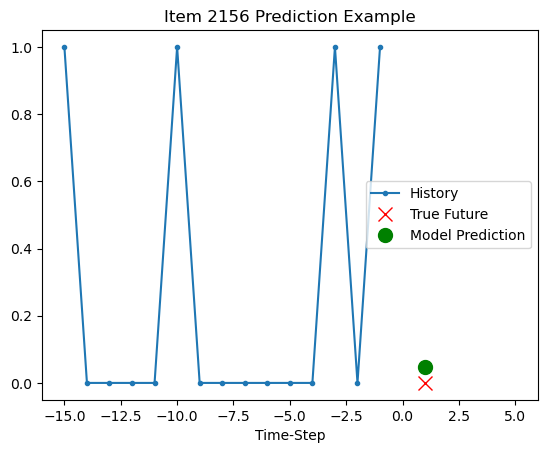

-----------------------------------
Current item is  1361
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_279 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_184 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_280 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_185 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_138 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 29882.0352 - val_loss: 119667.7656
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 97016.4297 - val_loss: 119.2520
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 1940.2581 - val_loss: 52.8342
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 723.1902 - val_loss: 36.5917
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 402.7668 - val_loss: 25.5489
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 290.3178 - val_loss: 19.2731
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 213.9572 - val_loss: 20.1421
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 185.3600 - val_loss: 12.2804
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 144.3360 - val_loss: 15.3426
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 118.7076 - val_loss: 41.7046
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - 

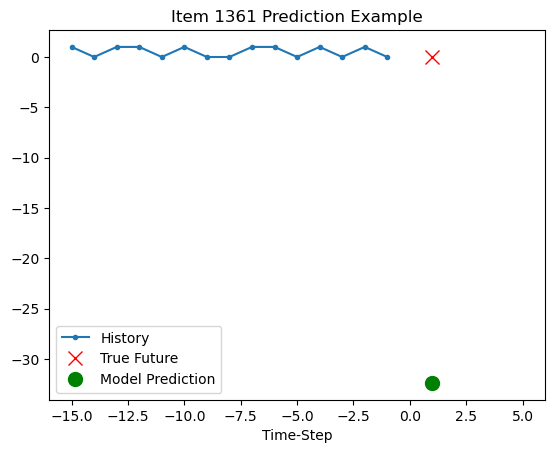

-----------------------------------
Current item is  1074
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_281 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_186 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_282 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_187 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_139 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - loss: 20917.5977 - val_loss: 523.7988
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 1820.9797 - val_loss: 77.7954
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 469.9118 - val_loss: 52.5772
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 193.7009 - val_loss: 10.2752
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 81.8956 - val_loss: 1.9827
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 39.7989 - val_loss: 2.4639
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 26.8196 - val_loss: 1.3595
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 15.0658 - val_loss: 0.3992
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 13.4954 - val_loss: 0.8631
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 10.6634 - val_loss: 0.6887
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 8.6248 - val

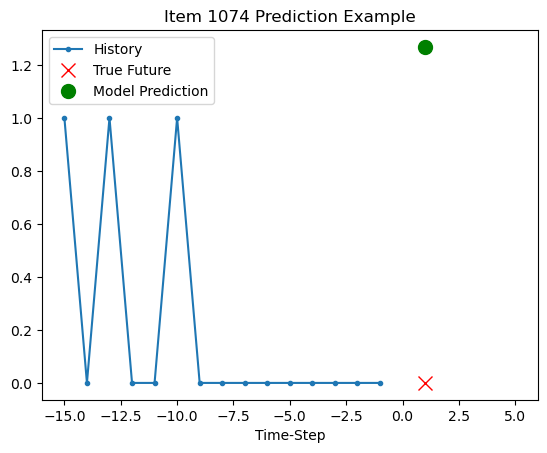

-----------------------------------
Current item is  1265
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_283 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_188 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_284 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_189 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_140 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - loss: 8322.6650 - val_loss: 116.4030
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 316.2222 - val_loss: 12.1824
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 83.1694 - val_loss: 2.9947
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 34.6315 - val_loss: 2.9784
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 17.8371 - val_loss: 0.6925
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 6.7460 - val_loss: 0.6268
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 6.0347 - val_loss: 2.5081
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 7.0590 - val_loss: 0.2629
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 3.4114 - val_loss: 0.1374
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 1.7789 - val_loss: 0.6894
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 1.3210 - val_loss: 0.11

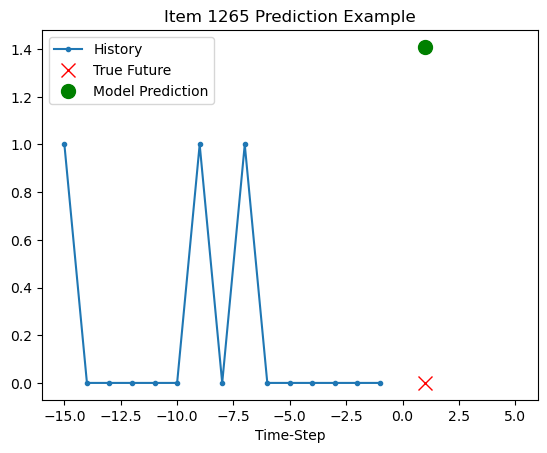

-----------------------------------
Current item is  2221
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_285 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_190 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_286 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_191 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_141 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - loss: 35925.5117 - val_loss: 1566.6349
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 2116.3655 - val_loss: 81.7741
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 430.7963 - val_loss: 136.3681
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - loss: 211.5713 - val_loss: 35.1650
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 118.7193 - val_loss: 23.1144
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 81.8371 - val_loss: 7.9310
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - loss: 57.1146 - val_loss: 7.6643
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 41.7110 - val_loss: 3.7283
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 32.5754 - val_loss: 3.0487
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 27.1959 - val_loss: 8.0489
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 23.3065 

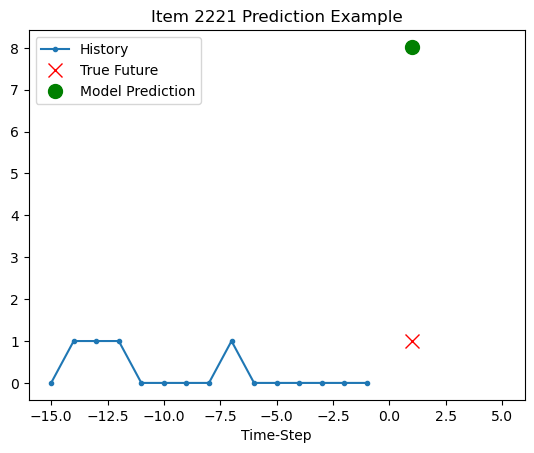

-----------------------------------
Current item is  1164
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_287 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_192 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_288 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_193 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_142 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - loss: 11416.3867 - val_loss: 231.5361
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 1104.9559 - val_loss: 41.3923
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 177.8463 - val_loss: 17.2359
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 76.4523 - val_loss: 5.7385
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 38.7141 - val_loss: 3.5160
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 25.2371 - val_loss: 3.1355
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 16.6843 - val_loss: 6.0632
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 11.6400 - val_loss: 2.5194
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 6.7764 - val_loss: 1.4476
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 5.9609 - val_loss: 0.5749
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 3.3708 - val_los

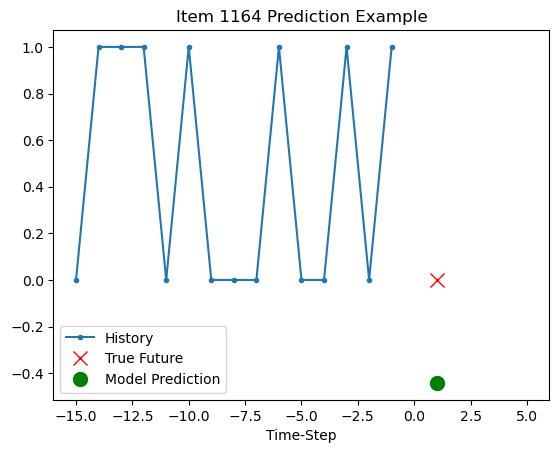

-----------------------------------
Current item is  2106
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_289 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_194 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_290 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_195 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_143 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - loss: 13085.9102 - val_loss: 315.2415
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 754.3457 - val_loss: 37.7731
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 170.2674 - val_loss: 30.6020
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 69.8272 - val_loss: 3.0887
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 30.7674 - val_loss: 1.3729
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 15.6875 - val_loss: 1.6926
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 9.5343 - val_loss: 2.3414
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 7.0649 - val_loss: 0.8414
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 4.9869 - val_loss: 0.3043
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 3.7756 - val_loss: 0.2602
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 2.4585 - val_loss: 

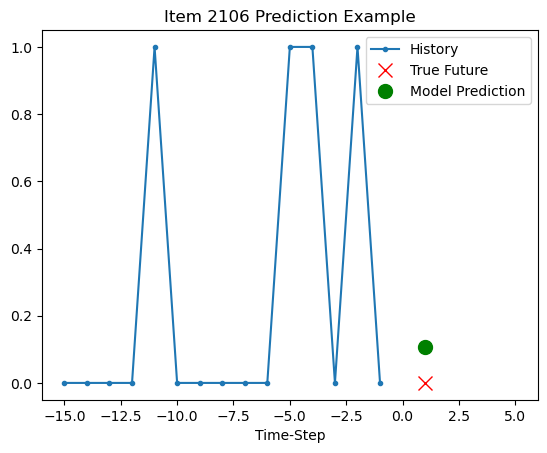

-----------------------------------
Current item is  2199
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_291 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_196 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_292 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_197 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_144 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - loss: 8127.8408 - val_loss: 680.4302
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 592.5879 - val_loss: 26.4985
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 78.3791 - val_loss: 4.8960
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 22.6474 - val_loss: 0.5114
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - loss: 3.1195 - val_loss: 0.2576
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 1.3928 - val_loss: 0.0700
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.8203 - val_loss: 0.0289
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.4228 - val_loss: 0.0128
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 0.2294 - val_loss: 0.0178
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 0.1942 - val_loss: 0.0139
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.1572 - val_loss: 0.005

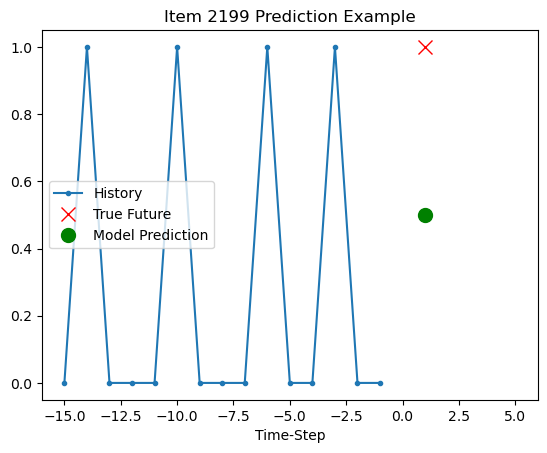

-----------------------------------
Current item is  1504
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_293 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_198 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_294 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_199 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_145 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - loss: 27361.2969 - val_loss: 856.7946
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 2915.4482 - val_loss: 258.5603
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 872.1925 - val_loss: 80.1317
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 383.4228 - val_loss: 68.7992
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 291.5343 - val_loss: 23.5859
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 163.3622 - val_loss: 16.9654
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 105.6384 - val_loss: 10.8264
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 67.3603 - val_loss: 5.3923
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 49.4094 - val_loss: 4.2467
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 32.3661 - val_loss: 4.8813
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 28.79

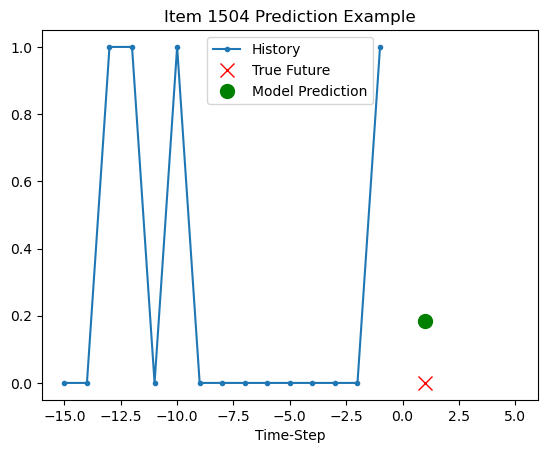

-----------------------------------
Current item is  1217
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_295 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_200 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_296 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_201 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_146 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - loss: 26720.2051 - val_loss: 3780.3308
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 10097.9482 - val_loss: 90.9688
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 573.0079 - val_loss: 35.5644
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 184.0097 - val_loss: 15.6040
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - loss: 91.8896 - val_loss: 4.3280
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 23.9071 - val_loss: 1.6444
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 13.0078 - val_loss: 4.6116
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 4.8410 - val_loss: 0.3697
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 2.7283 - val_loss: 0.1159
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 1.7987 - val_loss: 0.1589
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 3.2258 - val_

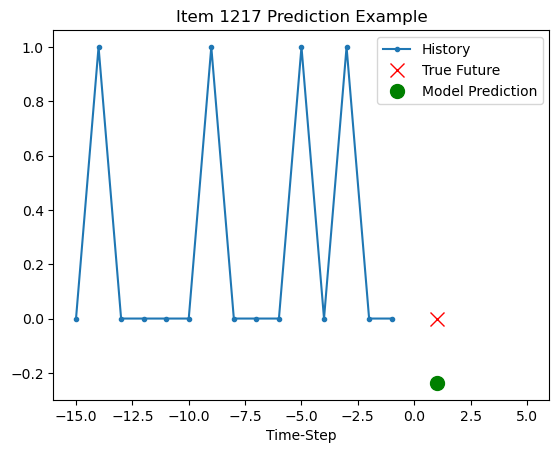

-----------------------------------
Current item is  2416
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_148"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_297 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_202 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_298 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_203 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_147 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - loss: 9094.2695 - val_loss: 415.5934
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 817.4766 - val_loss: 68.2044
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 223.5820 - val_loss: 26.5361
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 63.4532 - val_loss: 4.5100
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 11.2580 - val_loss: 0.4124
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 3.6658 - val_loss: 0.6942
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 1.6783 - val_loss: 0.1331
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 0.8753 - val_loss: 0.0372
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 0.6898 - val_loss: 0.0598
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 0.5096 - val_loss: 0.0233
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 0.5203 - val_loss: 0.

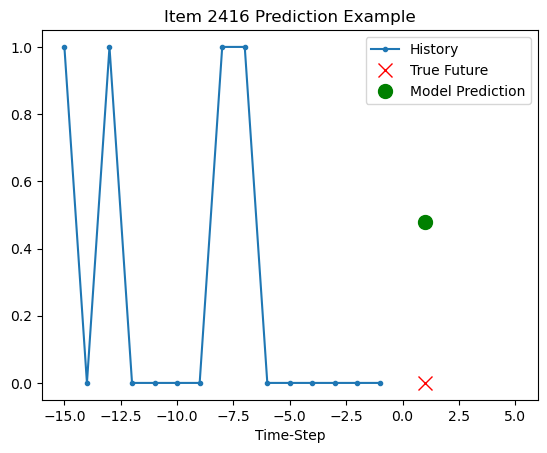

-----------------------------------
Current item is  1144
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_299 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_204 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_300 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_205 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_148 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - loss: 13991.3867 - val_loss: 1560.0195
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 2702.5930 - val_loss: 203.7880
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 673.2391 - val_loss: 93.6143
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 262.7306 - val_loss: 37.9598
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 121.4239 - val_loss: 18.7477
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 61.3078 - val_loss: 9.5012
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 30.0997 - val_loss: 4.7299
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 17.9337 - val_loss: 1.7755
Epoch 9/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 8.0625 - val_loss: 0.6316
Epoch 10/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 3.9434 - val_loss: 0.3600
Epoch 11/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 2.0804 - v

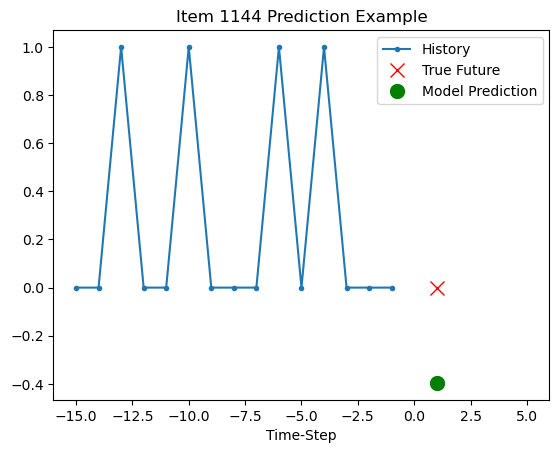

-----------------------------------
Current item is  2054
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_301 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_206 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_302 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_207 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_149 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - loss: 27475.6855 - val_loss: 385.4841
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 1731.7477 - val_loss: 145.0212
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 376.2201 - val_loss: 36.6563
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 182.3835 - val_loss: 14.9190
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 79.0177 - val_loss: 5.6637
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 48.6424 - val_loss: 3.9952
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 23.4958 - val_loss: 0.7651
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 11.3417 - val_loss: 1.3950
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 8.4354 - val_loss: 2.6701
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 6.2758 - val_loss: 0.6920
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 4.9987 - val_

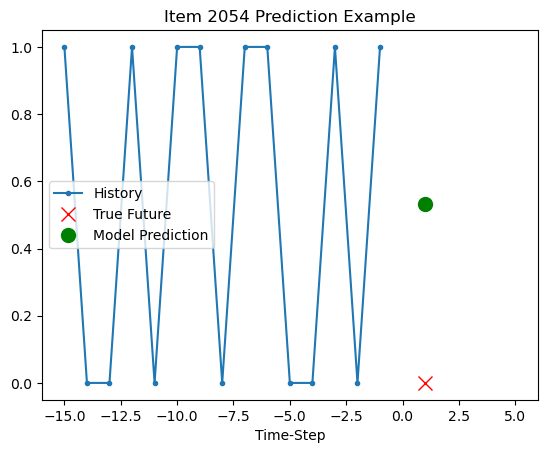

-----------------------------------
Current item is  1331
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_303 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_208 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_304 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_209 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_150 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - loss: 33926.3984 - val_loss: 914.1102
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 4459.9355 - val_loss: 256.1666
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 1583.3724 - val_loss: 170.3104
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 384.4293 - val_loss: 9.6343
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 58.0279 - val_loss: 3.2104
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 22.2286 - val_loss: 1.0264
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 11.5960 - val_loss: 2.0818
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 8.0785 - val_loss: 0.5921
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 6.4235 - val_loss: 0.6774
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 5.6328 - val_loss: 0.8505
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 4.5361 - val_

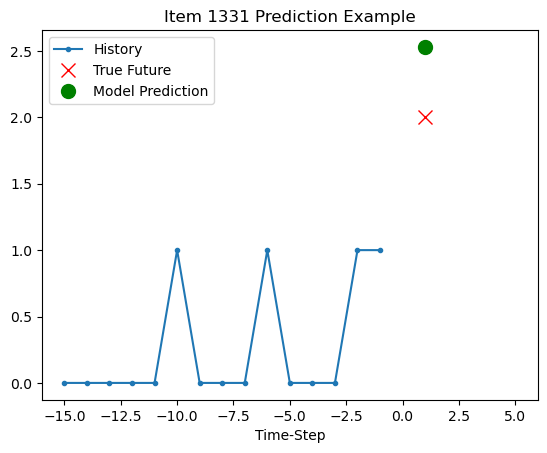

-----------------------------------
Current item is  2377
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_305 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_210 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_306 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_211 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_151 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - loss: 4183.4238 - val_loss: 61.1546
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 125.9009 - val_loss: 6.4626
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 24.7645 - val_loss: 1.6798
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 8.9117 - val_loss: 0.5688
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 4.4383 - val_loss: 0.3184
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 2.0638 - val_loss: 0.1638
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 1.2701 - val_loss: 0.1484
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 0.8496 - val_loss: 0.0511
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 0.4806 - val_loss: 0.0154
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 0.4489 - val_loss: 0.0086
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 0.2087 - val_loss: 0.0204
E

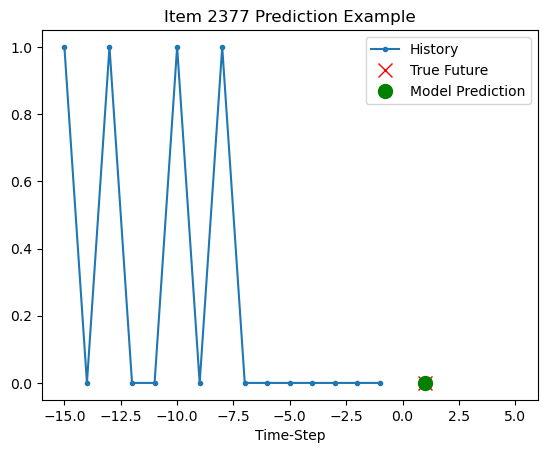

-----------------------------------
Current item is  2124
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_153"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_307 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_212 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_308 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_213 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_152 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - loss: 77748.6953 - val_loss: 8623.4561
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 18687.0879 - val_loss: 220.3259
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 1667.3567 - val_loss: 58.0999
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 495.5660 - val_loss: 26.3111
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 276.6446 - val_loss: 27.3185
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 201.9171 - val_loss: 16.6310
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 186.8736 - val_loss: 17.3321
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 128.8895 - val_loss: 19.3532
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 56.3507 - val_loss: 1.9922
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 30.2316 - val_loss: 1.3769
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 

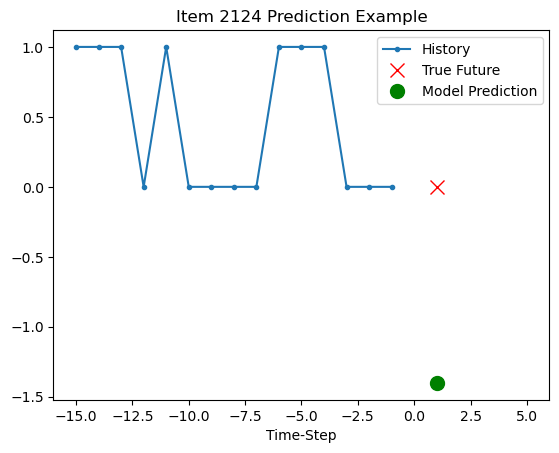

-----------------------------------
Current item is  2101
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_309 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_214 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_310 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_215 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_153 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - loss: 4596.3770 - val_loss: 95.3279
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 201.1535 - val_loss: 8.1043
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - loss: 48.1081 - val_loss: 2.2798
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - loss: 21.9064 - val_loss: 2.8067
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - loss: 12.0960 - val_loss: 0.7991
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 6.6001 - val_loss: 0.4042
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 4.4514 - val_loss: 0.3438
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - loss: 2.7699 - val_loss: 1.0724
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 2.0883 - val_loss: 0.4742
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - loss: 1.5510 - val_loss: 0.5974
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 1.0658 - val_loss: 0.0939

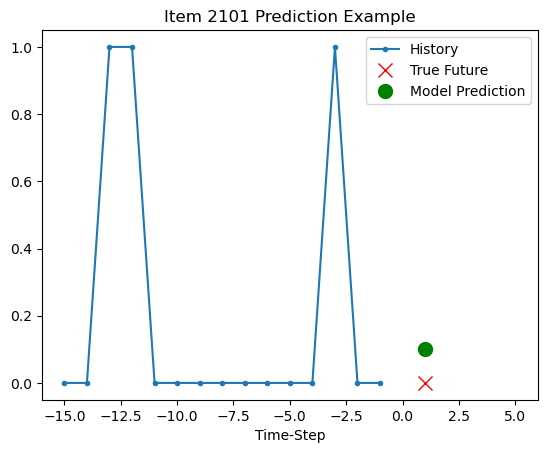

-----------------------------------
Current item is  1343
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_311 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_216 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_312 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_217 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_154 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - loss: 11506.0781 - val_loss: 34.2771
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - loss: 180.9903 - val_loss: 18.6587
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 61.4608 - val_loss: 10.0060
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - loss: 29.9688 - val_loss: 2.3365
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - loss: 7.8875 - val_loss: 0.4862
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - loss: 3.9073 - val_loss: 0.1897
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - loss: 1.6753 - val_loss: 0.0762
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - loss: 1.1489 - val_loss: 0.3866
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 1.1062 - val_loss: 0.1158
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - loss: 0.6748 - val_loss: 0.0187
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - loss: 0.4190 - val_loss: 0.01

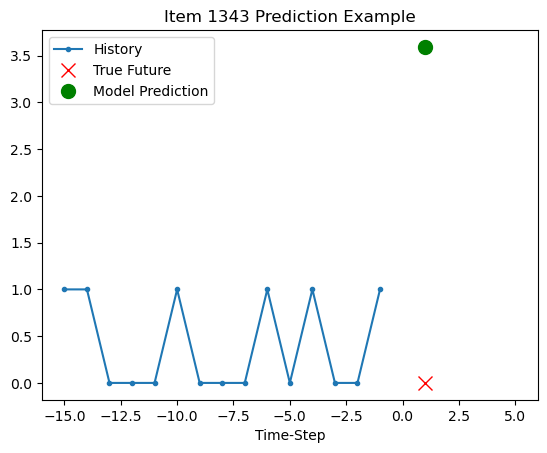

-----------------------------------
Current item is  1282
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_313 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_218 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_314 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_219 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_155 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - loss: 24126.5449 - val_loss: 37572.9062
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 27283.8320 - val_loss: 210.6883
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 1087.2947 - val_loss: 112.8808
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 318.7560 - val_loss: 79.4087
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 148.5492 - val_loss: 15.4328
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 86.4486 - val_loss: 11.7265
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 55.4236 - val_loss: 14.5651
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 46.3208 - val_loss: 9.2457
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 36.5434 - val_loss: 12.0495
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 22.5853 - val_loss: 27.1561
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 

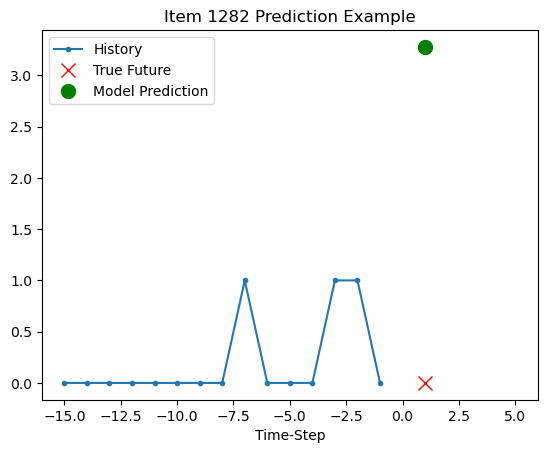

-----------------------------------
Current item is  2071
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_157"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_315 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_220 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_316 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_221 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_156 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - loss: 17841.7148 - val_loss: 303.4991
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 1005.1638 - val_loss: 1.2742
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 41.4888 - val_loss: 0.4523
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 11.1480 - val_loss: 0.2274
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 4.7374 - val_loss: 0.0675
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 2.9514 - val_loss: 0.0230
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 1.9527 - val_loss: 0.5829
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 1.5042 - val_loss: 0.8634
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 1.7897 - val_loss: 0.6065
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 0.7277 - val_loss: 0.0100
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 0.7133 - val_loss: 0.01

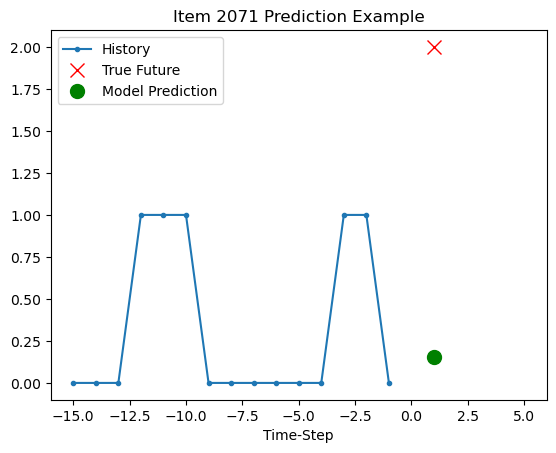

-----------------------------------
Current item is  1150
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_317 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_222 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_318 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_223 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_157 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - loss: 11214.9082 - val_loss: 284.7537
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - loss: 574.0168 - val_loss: 10.8568
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 135.6079 - val_loss: 8.9586
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 59.2822 - val_loss: 10.3243
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 26.6757 - val_loss: 2.1576
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 16.3684 - val_loss: 1.8340
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 8.9846 - val_loss: 1.2336
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 5.5760 - val_loss: 0.1891
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 3.4110 - val_loss: 0.8386
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 2.1602 - val_loss: 0.3900
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 1.6987 - val_loss: 

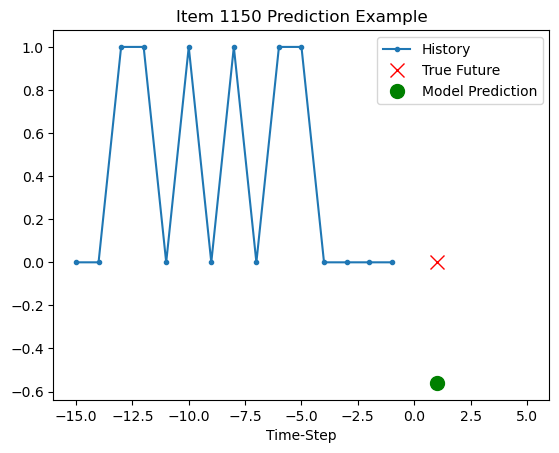

-----------------------------------
Current item is  2440
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_319 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_224 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_320 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_225 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_158 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - loss: 9610.1035 - val_loss: 82.6015
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 372.3842 - val_loss: 6.7885
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 73.6376 - val_loss: 3.2610
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 41.8971 - val_loss: 1.2933
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 23.0300 - val_loss: 0.5036
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 17.1519 - val_loss: 0.4794
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - loss: 10.2799 - val_loss: 0.1863
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - loss: 8.2328 - val_loss: 0.0860
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 6.0093 - val_loss: 0.0664
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 4.3283 - val_loss: 0.2106
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 4.5909 - val_loss: 0.05

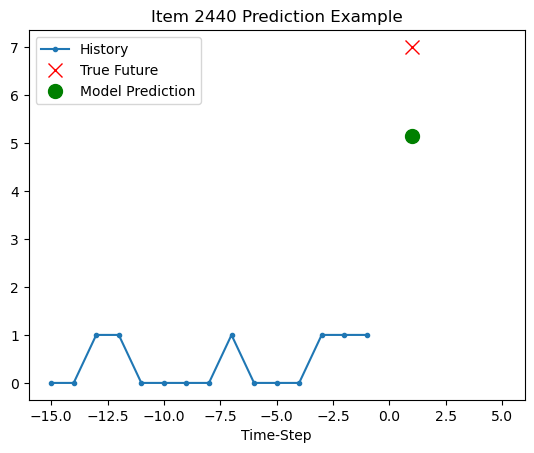

-----------------------------------
Current item is  2275
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_321 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_226 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_322 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_227 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - loss: 26791.0273 - val_loss: 29672.2324
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 53993.0273 - val_loss: 513.0013
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 673.9023 - val_loss: 31.1196
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 162.3504 - val_loss: 29.2547
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - loss: 114.7378 - val_loss: 15.9494
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 100.4408 - val_loss: 22.4459
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 69.6987 - val_loss: 13.6501
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 53.8268 - val_loss: 13.0580
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - loss: 47.1084 - val_loss: 11.2153
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 39.7829 - val_loss: 11.0481
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - loss: 

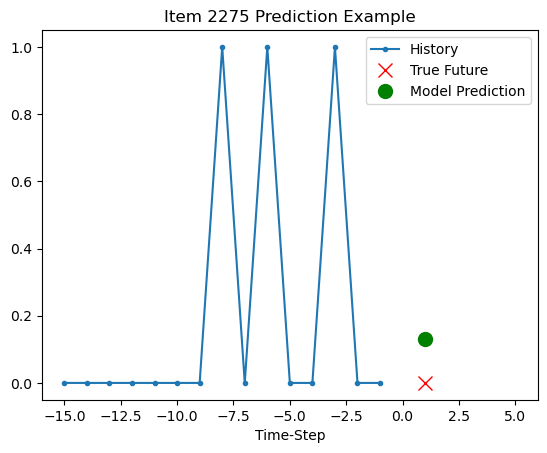

-----------------------------------
Current item is  2493
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_323 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_228 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_324 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_229 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_160 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - loss: 10158.6904 - val_loss: 958.8754
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - loss: 689.9169 - val_loss: 7.1501
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - loss: 44.1210 - val_loss: 2.0655
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - loss: 16.1113 - val_loss: 0.5033
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - loss: 9.5116 - val_loss: 0.2067
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 6.8276 - val_loss: 0.3904
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - loss: 4.6500 - val_loss: 0.1720
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - loss: 3.4991 - val_loss: 0.7321
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - loss: 2.6640 - val_loss: 0.0727
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - loss: 1.7941 - val_loss: 0.3509
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - loss: 1.0154 - val_loss: 0.022

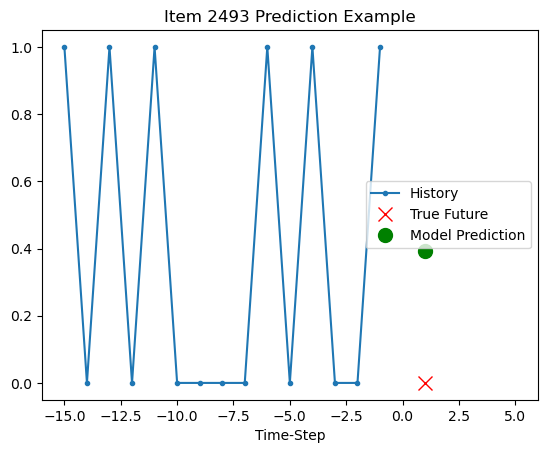

-----------------------------------
Current item is  2295
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_325 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_230 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_326 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_231 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_161 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6719s 147ms/step - loss: 196283.9375 - val_loss: 23562.9629
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - loss: 81273.2812 - val_loss: 1188.6191
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - loss: 7540.7725 - val_loss: 1201.7190
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - loss: 2459.8171 - val_loss: 230.5009
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - loss: 1023.4954 - val_loss: 121.3973
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - loss: 741.0065 - val_loss: 82.3422
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - loss: 562.4069 - val_loss: 135.8063
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - loss: 464.3417 - val_loss: 53.0934
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - loss: 368.8252 - val_loss: 39.1010
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - loss: 299.8866 - val_loss: 32.9394
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 148

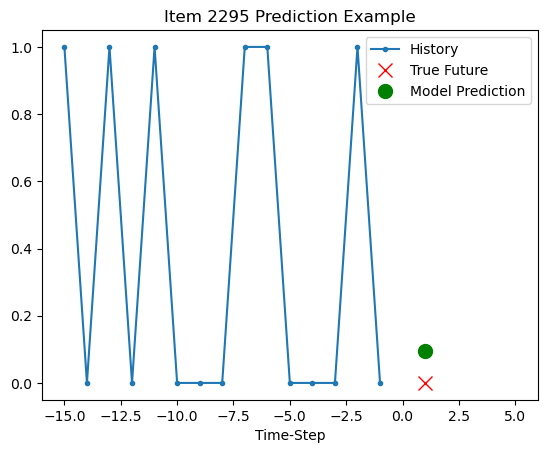

-----------------------------------
Current item is  1405
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_327 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_232 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_328 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_233 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_162 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - loss: 41853.9102 - val_loss: 1703.3793
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - loss: 3186.4482 - val_loss: 172.7683
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - loss: 781.2379 - val_loss: 44.5581
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - loss: 391.5133 - val_loss: 51.9665
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - loss: 236.6488 - val_loss: 24.3202
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - loss: 163.3580 - val_loss: 16.4731
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - loss: 116.3193 - val_loss: 14.6715
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 94.3411 - val_loss: 13.1433
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - loss: 73.4092 - val_loss: 8.0270
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - loss: 60.3665 - val_loss: 6.3872
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - loss: 50.

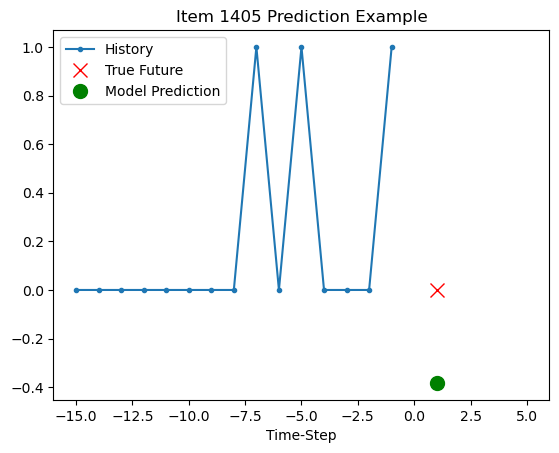

-----------------------------------
Current item is  1013
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_164"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_329 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_234 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_330 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_235 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_163 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - loss: 48021.1875 - val_loss: 10569.5479
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 29628.4316 - val_loss: 422.1935
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 2437.9456 - val_loss: 90.5340
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 847.9769 - val_loss: 41.7940
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 429.5881 - val_loss: 18.7420
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 248.9054 - val_loss: 9.5722
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - loss: 184.9539 - val_loss: 6.0886
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 126.2957 - val_loss: 6.0139
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 93.3610 - val_loss: 6.9112
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 76.2517 - val_loss: 5.8735
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 60

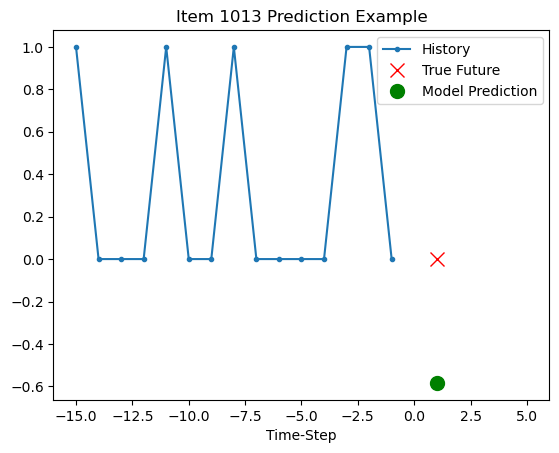

-----------------------------------
Current item is  1423
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_165"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_331 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_236 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_332 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_237 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_164 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - loss: 26175.9883 - val_loss: 13301.8105
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - loss: 10936.4199 - val_loss: 339.5075
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 481.1048 - val_loss: 37.9467
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 120.1431 - val_loss: 15.6336
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 143.3273 - val_loss: 25.1780
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - loss: 110.5352 - val_loss: 34.6851
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 45.1754 - val_loss: 7.8212
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 26.3397 - val_loss: 2.6428
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 15.0817 - val_loss: 2.0156
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 11.1229 - val_loss: 1.0675
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 10.7

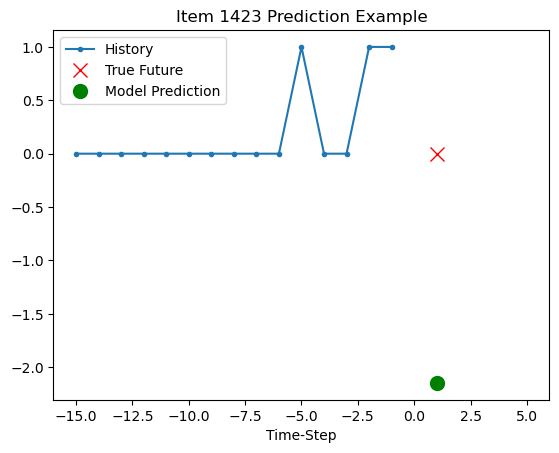

-----------------------------------
Current item is  2067
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_333 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_238 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_334 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_239 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_165 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - loss: 49758.1289 - val_loss: 4100.7563
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 31404.7949 - val_loss: 359.1188
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 2782.4688 - val_loss: 49.1615
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 932.6702 - val_loss: 23.3819
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 410.5623 - val_loss: 19.1208
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 217.5927 - val_loss: 15.0354
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - loss: 125.4185 - val_loss: 6.6713
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - loss: 90.3995 - val_loss: 5.8950
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 81.1977 - val_loss: 11.3496
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - loss: 75.9165 - val_loss: 12.2959
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - loss: 5

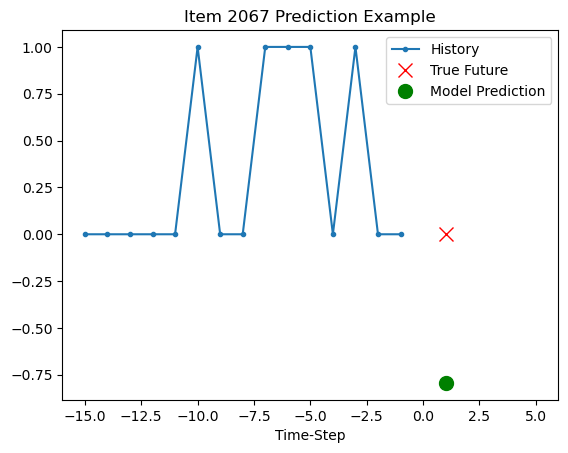

-----------------------------------
Current item is  2286
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_335 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_240 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_336 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_241 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_166 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - loss: 8558.5498 - val_loss: 63.7728
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 134.5322 - val_loss: 20.0135
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 30.3057 - val_loss: 9.8294
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 17.3734 - val_loss: 4.8284
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 11.0160 - val_loss: 1.3612
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 6.2297 - val_loss: 0.9176
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 4.5474 - val_loss: 0.5704
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 3.5358 - val_loss: 0.5308
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 2.4426 - val_loss: 0.2971
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 1.4475 - val_loss: 0.2013
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 1.0841 - val_loss: 0.166

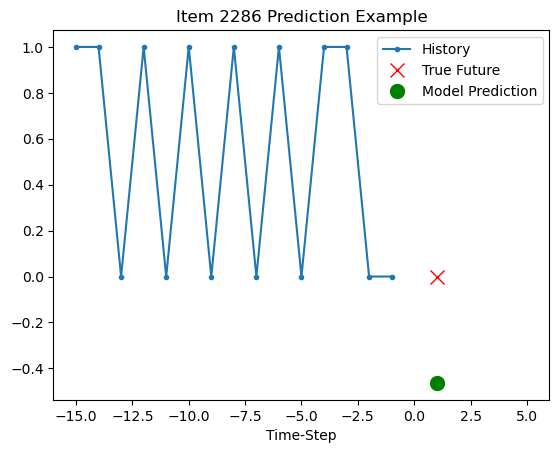

-----------------------------------
Current item is  2129
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_337 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_242 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_338 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_243 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_167 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - loss: 3730.8979 - val_loss: 43.3244
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 102.9349 - val_loss: 6.8940
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 29.9634 - val_loss: 0.7394
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 6.6715 - val_loss: 0.9451
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 6.0368 - val_loss: 0.2754
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 2.2330 - val_loss: 0.0953
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 1.1339 - val_loss: 0.0423
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 0.8631 - val_loss: 0.0169
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 0.5747 - val_loss: 0.0250
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 0.5116 - val_loss: 0.0209
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 0.3482 - val_loss: 0.0371
E

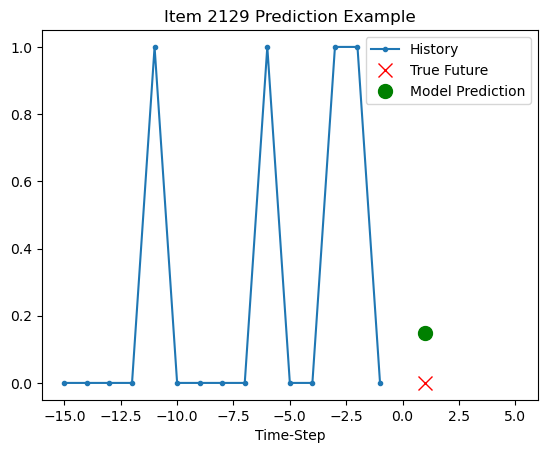

-----------------------------------
Current item is  1082
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_339 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_244 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_340 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_245 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_168 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - loss: 22520.6328 - val_loss: 1209.0499
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 1057.8999 - val_loss: 120.9671
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - loss: 250.2575 - val_loss: 23.9698
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 66.1376 - val_loss: 2.2222
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 11.5387 - val_loss: 1.1044
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 5.6733 - val_loss: 0.5026
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - loss: 3.5553 - val_loss: 0.3384
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 2.7508 - val_loss: 0.2288
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - loss: 2.2894 - val_loss: 0.0988
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 0.9104 - val_loss: 0.3713
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - loss: 0.9204 - val_loss

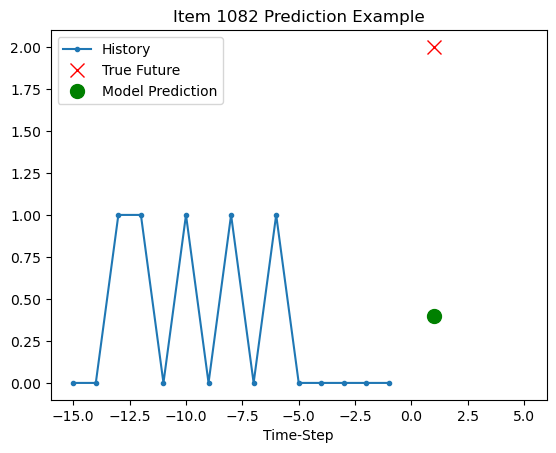

-----------------------------------
Current item is  1254
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_170"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_341 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_246 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_342 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_247 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_169 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - loss: 15933.2725 - val_loss: 941.1097
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - loss: 4106.5435 - val_loss: 67.1737
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 496.1465 - val_loss: 18.8257
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - loss: 175.1661 - val_loss: 13.0893
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - loss: 83.0492 - val_loss: 7.7522
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step - loss: 47.6428 - val_loss: 4.6468
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 23.6646 - val_loss: 2.5897
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 15.2227 - val_loss: 1.2845
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 14.9872 - val_loss: 4.7233
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 13.0479 - val_loss: 4.2775
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 13.6110 - va

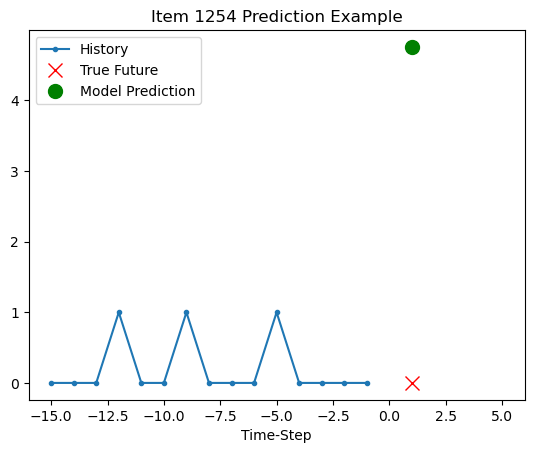

-----------------------------------
Current item is  2257
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_171"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_343 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_248 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_344 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_249 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_170 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - loss: 7655.8535 - val_loss: 780.7281
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - loss: 698.8498 - val_loss: 8.7090
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - loss: 41.9981 - val_loss: 2.2838
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - loss: 19.0797 - val_loss: 1.8406
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - loss: 12.3102 - val_loss: 0.7391
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - loss: 6.7863 - val_loss: 0.5995
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 5.6349 - val_loss: 0.3972
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - loss: 3.8613 - val_loss: 0.5598
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - loss: 2.5730 - val_loss: 0.2595
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - loss: 2.3194 - val_loss: 0.1624
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - loss: 1.8419 - val_loss: 0.232

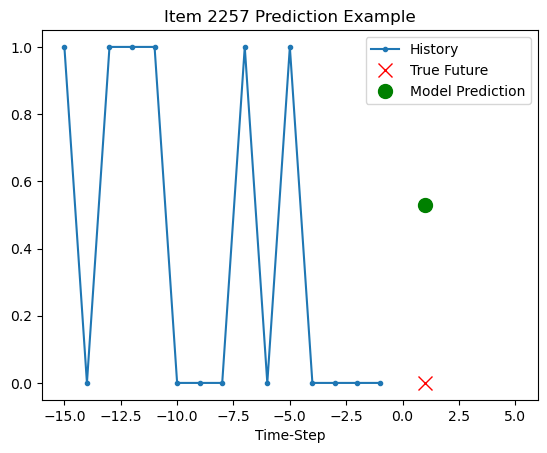

-----------------------------------
Current item is  2226
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_172"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_345 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_250 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_346 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_251 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_171 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - loss: 19788.1855 - val_loss: 274.8459
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - loss: 1005.2773 - val_loss: 42.6862
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - loss: 296.0948 - val_loss: 24.6790
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - loss: 166.2050 - val_loss: 12.2961
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - loss: 109.4815 - val_loss: 5.9555
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - loss: 68.3742 - val_loss: 4.3653
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - loss: 43.0775 - val_loss: 1.7519
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - loss: 31.2232 - val_loss: 3.2773
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - loss: 23.2122 - val_loss: 2.0105
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - loss: 23.7326 - val_loss: 1.4713
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - loss: 21.1586 - v

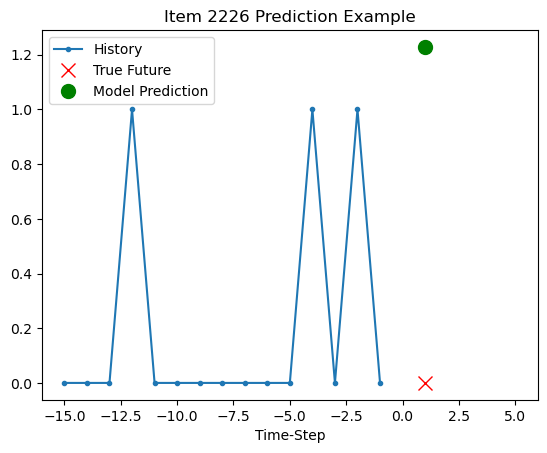

-----------------------------------
Current item is  1283
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_173"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_347 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_252 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_348 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_253 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_172 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - loss: 2103.4707 - val_loss: 13.8779
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - loss: 77.4016 - val_loss: 3.1525
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - loss: 8.4946 - val_loss: 0.2621
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - loss: 1.2050 - val_loss: 0.2581
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - loss: 0.5822 - val_loss: 0.0142
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - loss: 0.2352 - val_loss: 0.2116
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - loss: 0.2359 - val_loss: 0.0146
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - loss: 0.1990 - val_loss: 0.0643
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - loss: 0.1490 - val_loss: 0.0518
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - loss: 0.1222 - val_loss: 0.0526
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 0.1653 - val_loss: 0.0120
Epo

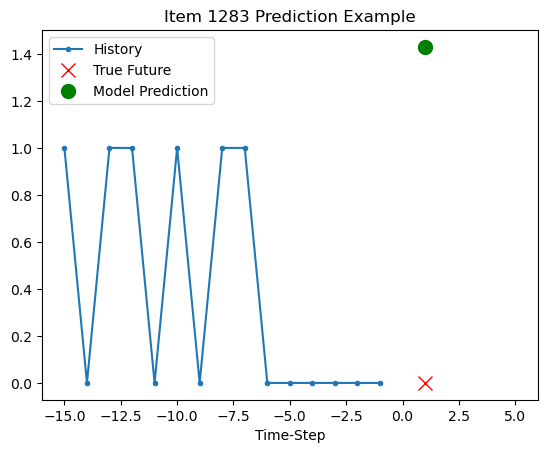

-----------------------------------
Current item is  2141
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_349 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_254 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_350 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_255 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_173 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - loss: 9047.7363 - val_loss: 252.6134
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - loss: 452.2170 - val_loss: 10.1615
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - loss: 37.2436 - val_loss: 1.7122
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 8.6455 - val_loss: 0.7565
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - loss: 4.2641 - val_loss: 0.3718
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 2.4616 - val_loss: 1.3413
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 1.9163 - val_loss: 0.0338
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 0.8954 - val_loss: 0.0559
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - loss: 0.4216 - val_loss: 0.0259
Epoch 10/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - loss: 0.2358 - val_loss: 0.0094
Epoch 11/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 0.2857 - val_loss: 0.1292

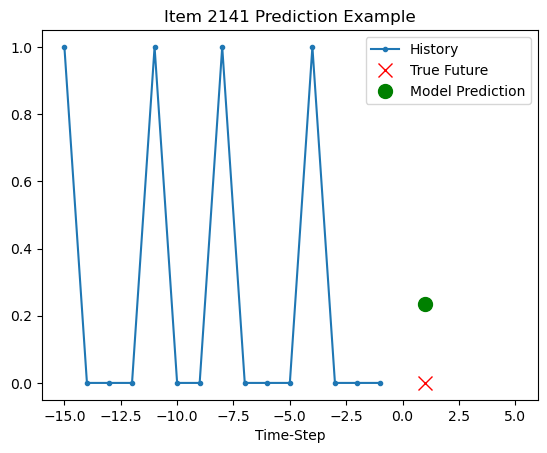

-----------------------------------
Current item is  2501
Data types of train_dummy after one-hot encoding:
id             object
item_id        object
dept_id        object
d              object
num_sold        int64
wm_yr_wk        int64
month           int64
year            int64
sell_price    float64
event_type    float64
store_id_1       bool
store_id_2       bool
store_id_3       bool
store_id_4       bool
state_id_1       bool
state_id_2       bool
state_id_3       bool
weekday_1        bool
weekday_2        bool
weekday_3        bool
weekday_4        bool
weekday_5        bool
weekday_6        bool
weekday_7        bool
snap_0           bool
snap_1           bool
dtype: object
Index(['d', 'month', 'sell_price', 'event_type', 'store_id_1', 'store_id_2',
       'store_id_3', 'store_id_4', 'state_id_1', 'state_id_2', 'state_id_3',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'snap_0', 'snap_1'],
      dtype='object')
Orig

Model: "sequential_175"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_351 (LSTM)                      │ (None, 15, 256)             │         283,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_256 (Dropout)                │ (None, 15, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_352 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_257 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_174 (Dense)                    │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 809,217 (3.09 MB)

 Trainable params: 809,217 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - loss: 15058.1328 - val_loss: 583.1071
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - loss: 1731.4601 - val_loss: 13.6283
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - loss: 182.6647 - val_loss: 58.2110
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - loss: 91.0743 - val_loss: 19.8143
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - loss: 58.1783 - val_loss: 23.0297
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - loss: 35.0219 - val_loss: 10.2392
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - loss: 25.0402 - val_loss: 3.9456
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - loss: 17.6153 - val_loss: 2.8852
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 13.1647 - val_loss: 3.6694
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 9.9337 - val_loss: 2.1119
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - loss: 9.3490 - val

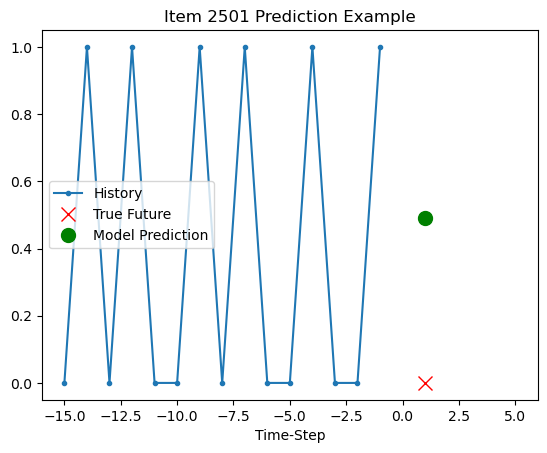

-----------------------------------
Overall Validation MSE: 17.821836
Overall Validation RMSE: 4.2215915
Overall Validation MAE: 1.3745992
Overall Validation R-squared: -2.6647260009051483


In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

def create_xy_data(df, pre_type = ""):
    x_train_id = (df['id'] + "_" + pre_type).values
    idx = np.unique(x_train_id, return_index=True)[1]
    idx.sort()
    x_train_id = x_train_id[idx]
    y_train = df['num_sold'].values
    df = df.drop(['id','num_sold','item_id', 'dept_id','wm_yr_wk', 'year'],axis=1)
    return df, y_train, x_train_id

def create_x(df, pre_type=""):
    x_train_id = (df['id'] + "_" + pre_type).values
    idx = np.unique(x_train_id, return_index=True)[1]
    idx.sort()
    x_train_id = x_train_id[idx]
    df = df.drop(['id','num_sold','item_id', 'dept_id', 'wm_yr_wk','year'],axis=1)
    return df, x_train_id

def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])

    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0] - 1, (future + 2) * 2])
    plt.xlabel('Time-Step')
    return plt

LOOKBACK_MAX     = 28  #28? 14?
LOOKBACK_ARR     = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

y_val_pre_all     = []
y_eval_pre_all    = []
y_val_true_all    = []
val_id_all        = []
eval_id_all       = []
SE_list           = [] 
number_of_trained = 0
y_true_all    = []
y_pred_all    = []
unique_items  = train_data['item_id'].unique()
target_scaler = MinMaxScaler(feature_range=(0, 1))

y_eval_output = []

# create a model for each product
while number_of_trained < 100 and number_of_trained < len(unique_items):
    item = unique_items[number_of_trained]
    print("-----------------------------------")
    print("Current item is ", item)

    # Filter data for the current item
    item_train_data = train_data[train_data['item_id'] == item].reset_index(drop=True)
    item_val_data     = validation_data[validation_data['item_id'] == item].reset_index(drop=True)
    item_eval_data    = testing_data[testing_data['item_id'] == item].reset_index(drop=True)

    item_train_data['state_id'] = item_train_data['state_id'].astype(str)
    item_train_data['store_id'] = item_train_data['store_id'].astype(str)

    item_val_data['state_id'] = item_val_data['state_id'].astype(str)
    item_val_data['store_id'] = item_val_data['store_id'].astype(str)

    item_eval_data['state_id'] = item_eval_data['state_id'].astype(str)
    item_eval_data['store_id'] = item_eval_data['store_id'].astype(str)

    # Since it is not reasonable to use data from different stores when extracting the previous 14 days
    state_store_list         = (item_train_data['state_id'] + '_' + item_train_data['store_id']).to_numpy()
    val_state_store_list = (item_val_data['state_id'] + '_' + item_val_data['store_id']).to_numpy()
    eval_state_store_list = (item_eval_data['state_id'] + '_' + item_eval_data['store_id']).to_numpy()

    # Transform categorical data using One-hot-encoding
    train_dummy         = pd.get_dummies(item_train_data, columns=['store_id','state_id', 'weekday', 'snap'], drop_first=False)
    train_columns         = train_dummy.columns
    val_dummy           = pd.get_dummies(item_val_data,     columns=['store_id','state_id', 'weekday', 'snap'], drop_first=False)
    eval_dummy          = pd.get_dummies(item_eval_data,    columns=['store_id','state_id', 'weekday', 'snap'], drop_first=False)
    print("Data types of train_dummy after one-hot encoding:")
    print(train_dummy.dtypes)

    missing_cols = set(train_dummy.columns) - set(eval_dummy.columns)
    for col in missing_cols:
        eval_dummy[col] = 0  # 补全缺失的列，并设为0
    eval_dummy = eval_dummy[train_dummy.columns]  # 保持列顺序一致
    eval_dummy = eval_dummy.reindex(columns=train_dummy.columns, fill_value=0)
    # Create dataframe
    x_data, y_data, data_id = create_xy_data(train_dummy)
    x_val, y_val, val_id     = create_xy_data(val_dummy, pre_type="validation")
    x_eval, eval_id          = create_x(eval_dummy, pre_type="evaluation")

    val_id_all.append(val_id)
    eval_id_all.append(eval_id)

    # Standardize price
    scaler_x = StandardScaler()
    x_data['sell_price']     = scaler_x.fit_transform(np.array(x_data['sell_price']).reshape(-1,1))
    x_val['sell_price']       = scaler_x.transform(np.array(x_val['sell_price']).reshape(-1,1))
    x_eval['sell_price']    = scaler_x.transform(np.array(x_eval['sell_price']).reshape(-1,1))
    x_columns = x_data.columns
    print(x_columns)

    # Scale target variable
    print(f"Original y_data range: min={np.min(y_data)}, max={np.max(y_data)}")
    y_data_scaled = target_scaler.fit_transform(y_data.reshape(-1, 1)).flatten()
    print(f"Scaled y_data range: min={np.min(y_data_scaled)}, max={np.max(y_data_scaled)}")
    y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
    print(f"Scaled y_val range: min={np.min(y_val_scaled)}, max={np.max(y_val_scaled)}")

    x_time = []
    y_time = []
    x_val_time = []
    y_val_time = []
    x_eval_time = []
    i = LOOKBACK_MAX

    # Store-specific data extraction and handling
    unique_stores = np.unique(state_store_list)
    for store in unique_stores:
        train_indices = np.where(state_store_list == store)[0]
        val_indices   = np.where(val_state_store_list == store)[0]
        eval_indices  = np.where(eval_state_store_list == store)[0]

        store_x_data = x_data.iloc[train_indices].reset_index(drop=True)
        store_y_data = y_data_scaled[train_indices]
        store_x_val  = x_val.iloc[val_indices].reset_index(drop=True)
        store_y_val  = y_val_scaled[val_indices]
        store_x_eval = x_eval.iloc[eval_indices].reset_index(drop=True)

        # Convert boolean columns to integers
        bool_cols = ['store_id_1', 'store_id_2', 'store_id_3', 'store_id_4',
                     'state_id_1', 'state_id_2', 'state_id_3',
                     'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
                     'snap_0', 'snap_1']
        for col in bool_cols:
            if col in store_x_data.columns:
                store_x_data[col] = store_x_data[col].astype(int)
            if col in store_x_val.columns:
                store_x_val[col] = store_x_val[col].astype(int)
            if col in store_x_eval.columns:
                store_x_eval[col] = store_x_eval[col].astype(int)

        #看看有没有问题
        for col in ['event_type_1', 'event_type_2']:
            if col in store_x_data.columns:
                store_x_data[col] = pd.to_numeric(store_x_data[col], errors='coerce')
            if col in store_x_val.columns:
                store_x_val[col] = pd.to_numeric(store_x_val[col], errors='coerce')
            if col in store_x_eval.columns:
                store_x_eval[col] = pd.to_numeric(store_x_eval[col], errors='coerce')

        # Process training data for lookback
        for i in range(LOOKBACK_MAX, len(store_x_data)):
            lookback_data = []
            for lb in LOOKBACK_ARR:
                if i - lb >= 0:
                    lookback_data.append(store_x_data.iloc[i - lb].values.tolist())
                else:
                    lookback_data.append([0] * store_x_data.shape[1])
            x_time.append(lookback_data)
            y_time.append(store_y_data[i])

        # Process validation data for lookback
        for i in range(LOOKBACK_MAX, len(store_x_val)):
            lookback_data = []
            for lb in LOOKBACK_ARR:
                if i - lb >= 0:
                    lookback_data.append(store_x_val.iloc[i - lb].values.tolist())
                else:
                    lookback_data.append([0] * store_x_val.shape[1])
            x_val_time.append(lookback_data)
            y_val_time.append(store_y_val[i])

        for i in range(LOOKBACK_MAX, len(store_x_eval)):
            lookback_data = []
            for lb in LOOKBACK_ARR:
                if i - lb >= 0:
                    lookback_data.append(store_x_eval.iloc[i - lb].values.tolist())
                else:
                    lookback_data.append([0] * store_x_eval.shape[1])
            x_eval_time.append(lookback_data)

    x_time     = np.array(x_time).astype(np.float32)
    y_time     = np.array(y_time).astype(np.float32)
    x_val_time = np.array(x_val_time).astype(np.float32)
    y_val_time = np.array(y_val_time).astype(np.float32)
    x_eval_time= np.array(x_eval_time).astype(np.float32)


    print(f"x_eval_time shape before reshape: {x_eval_time.shape}")
    print(f"x_data.shape[1]: {x_data.shape[1]}")
    print(f"LOOKBACK_ARR.shape[0]: {LOOKBACK_ARR.shape[0]}")
    print(f"item_eval_data.shape: {item_eval_data.shape}")
    unique_stores = np.unique(eval_state_store_list)
    for store in unique_stores:
        eval_indices = np.where(eval_state_store_list == store)[0]
        store_x_eval = x_eval.iloc[eval_indices].reset_index(drop=True)
        print(f"store_x_eval.shape: {store_x_eval.shape}")


    x_time = x_time.reshape((x_time.shape[0], LOOKBACK_ARR.shape[0], x_data.shape[1]))
    x_val_time = x_val_time.reshape((x_val_time.shape[0], LOOKBACK_ARR.shape[0], x_data.shape[1]))
    x_eval_time = x_eval_time.reshape((x_eval_time.shape[0], LOOKBACK_ARR.shape[0], x_eval.shape[1]))

    model = Sequential()
    model.add(Input(shape=(LOOKBACK_ARR.shape[0], x_data.shape[1])))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.summary()

    number_of_trained +=1

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(x = x_time,
                        y = y_time,
                        epochs=100,
                        shuffle=True,
                        batch_size=128,
                        validation_split = 0.1,
                        verbose=1,
                        callbacks=[early_stopping])
    # Predict
    y_val_pre_scaled = model.predict(x_val_time).reshape(-1,)
    y_val_pre = target_scaler.inverse_transform(y_val_pre_scaled.reshape(-1, 1)).flatten()
    y_val_true_original = target_scaler.inverse_transform(y_val_time.reshape(-1, 1)).flatten()
    y_val_pre = np.maximum(0, y_val_pre)

    y_val_pre_all.extend(y_val_pre)
    y_val_true_all.extend(y_val_true_original)
    print("Sample raw predictions (after inverse transform and clipping):", y_val_pre[:5])
    MSE = mean_squared_error(y_val_true_original, y_val_pre)
    SE_list.append(MSE*len(y_val_pre))
    print("RMSE = ", np.sqrt(MSE))

    r2 = r2_score(y_val_true_original, y_val_pre)
    print(f"Validation R-squared for item {item}: {r2}")

    y_eval_pre_scaled = model.predict(x_eval_time).reshape(-1,)
    y_eval_pre = target_scaler.inverse_transform(y_eval_pre_scaled.reshape(-1, 1)).flatten()
    y_eval_pre = np.maximum(0, y_eval_pre)
    if len(y_eval_pre) >= 28:
        y_eval_output.append(y_eval_pre[-28:])
    else:
        padding = np.zeros(28 - len(y_eval_pre))
        y_eval_output.append(np.concatenate([y_eval_pre, padding]))

    print(f"Predicted y_val range (after inverse transform and clipping): min={np.min(y_val_pre)}, max={np.max(y_val_pre)}")
    print(f"True y_val range (after inverse transform): min={np.min(y_val_true_original)}, max={np.max(y_val_true_original)}")

    #可视化图表-折线图
    plot_idx = np.random.randint(0, len(x_val_time))
    plot_sample = x_val_time[plot_idx]
    true_value_scaled = y_val_time[plot_idx]
    prediction_scaled = y_val_pre_scaled[plot_idx]

    true_value_original = target_scaler.inverse_transform(np.array([true_value_scaled]).reshape(-1, 1)).flatten()[0]
    prediction_original = target_scaler.inverse_transform(np.array([prediction_scaled]).reshape(-1, 1)).flatten()[0]

    plot_data = [
        plot_sample[:, -1],
        np.array([true_value_original]),
        np.array([prediction_original])]
    plt = show_plot(plot_data, delta=1, title=f'Item {item} Prediction Example')
    plt.show()

from sklearn.metrics import r2_score, mean_absolute_error
#给出总体的结果
overall_mse = mean_squared_error(y_val_true_all, y_val_pre_all)
overall_rmse = np.sqrt(overall_mse)
overall_r2 = r2_score(y_val_true_all, y_val_pre_all)
overall_mae = mean_absolute_error(y_val_true_all, y_val_pre_all)
print("-----------------------------------")
print("Overall Validation MSE:", overall_mse)
print("Overall Validation RMSE:", overall_rmse)
print("Overall Validation MAE:", overall_mae)
print("Overall Validation R-squared:", overall_r2)

In [41]:
y_val_pre_all = np.array(y_val_pre_all, dtype=object)
y_eval_pre_all = np.array(y_eval_pre_all, dtype=object)

def truncate_to_divisible(arr, divisor=28):
    if isinstance(arr, (list, np.ndarray)):
        current_size = len(arr)
        new_size = current_size - (current_size % divisor)
        return arr[:new_size]
    else:
        print(f"Warning: Skipping scalar element: {arr}")
        return np.array([]) # Return an empty array or handle as needed

y_val_output = [truncate_to_divisible(x).reshape(-1, 28) for x in y_val_pre_all if isinstance(x, (list, np.ndarray))]
y_eval_output = [truncate_to_divisible(x).reshape(-1, 28) for x in y_eval_pre_all if isinstance(x, (list, np.ndarray))]

# Check shapes
for i, arr in enumerate(y_val_output[:5]):
    print(f"Array {i}: shape {arr.shape}")

In [42]:
val_id_all = np.array(val_id_all)
eval_id_all = np.array(eval_id_all)

val_id_output = val_id_all.reshape(val_id_all.shape[0]*val_id_all.shape[1])
eval_id_output = eval_id_all.reshape(eval_id_all.shape[0]*eval_id_all.shape[1])
print(val_id_output.shape, eval_id_output.shape)

(1000,) (1000,)


In [43]:
y_val_output = [arr.flatten() for arr in y_val_output]

max_length = max(len(arr) for arr in y_val_output)
padded = [np.pad(arr, (0, max_length - len(arr)), 'constant') for arr in y_val_output]

y_val_output = np.vstack(padded)

if y_val_output.shape[1] % 28 != 0:
    padded_length = ((y_val_output.shape[1] + 27) // 28) * 28
    y_val_output = np.pad(y_val_output, ((0, 0), (0, padded_length - y_val_output.shape[1])), 'constant')
y_val_output = y_val_output.reshape(-1, 28)
num_samples = y_val_output.shape[0]

if len(val_id_output) > num_samples:
    val_id_output = val_id_output[:num_samples]
elif len(val_id_output) < num_samples:
    val_id_output = np.concatenate([val_id_output, np.full(num_samples - len(val_id_output), np.nan)])

output_cols = ['id'] + [f'F{i+1}' for i in range(28)]

val_df = pd.DataFrame(
    {'id': val_id_output},
    columns=['id'] + [f'F{i+1}' for i in range(28)]
)
for i in range(28):
    val_df[f'F{i+1}'] = y_val_output[:, i]

print(val_df.head())
print(f"Final shape: {val_df.shape}")

ValueError: max() iterable argument is empty

In [106]:
y_eval_output = [np.array(arr).flatten() for arr in y_eval_output]

max_length = 0
if y_eval_output:
    max_length = max(len(arr) for arr in y_eval_output)

padded = [np.pad(arr, (0, max_length - len(arr)), 'constant') for arr in y_eval_output]

y_eval_output = np.vstack(padded) if padded else np.empty((0, 0))
if y_eval_output.shape[1] < 28:
    y_eval_output = np.pad(y_eval_output, ((0,0),(0,28-y_eval_output.shape[1])), 'constant')
elif y_eval_output.shape[1] > 28:
    y_eval_output = y_eval_output[:, :28]
num_samples = y_eval_output.shape[0]

if len(eval_id_output) != num_samples:
    print(f"Adjusting IDs: had {len(eval_id_output)}, need {num_samples}")
    if len(eval_id_output) > num_samples:
        eval_id_output = eval_id_output[:num_samples]
    else:
        placeholder_ids = [f"eval_{x}" for x in range(len(eval_id_output), num_samples)]
        eval_id_output = np.concatenate([eval_id_output, placeholder_ids])

eval_df = pd.DataFrame({'id': eval_id_output})
for i in range(28):
    eval_df[f'F{i+1}'] = y_eval_output[:, i]

if 'output_cols' in globals():
    eval_df = eval_df[output_cols]

val_df.to_csv("HOUSEHOLD_output_validation.csv", index =False)
eval_df.to_csv("HOUSEHOLD_output_evauation.csv", index =False)

Adjusting IDs: had 100, need 0
